<h3> DAI Minor - 1 </h3>

<h4> Mukul Shingwani </h4>

<h4> B20AI023 </h4>

## diff color functions

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt


def rgb2xyz(rgb_image,device):
    mt = torch.tensor([[0.4124, 0.3576, 0.1805], 
                   [0.2126, 0.7152, 0.0722],
                   [0.0193, 0.1192, 0.9504]]).to(device)
    mask1=(rgb_image > 0.0405).float()
    mask1_no=1-mask1
    temp_img = mask1* (((rgb_image + 0.055 ) / 1.055 ) ** 2.4)
    temp_img = temp_img+mask1_no * (rgb_image / 12.92)    
    temp_img = 100 * temp_img

    res = torch.matmul(mt, temp_img.permute(1, 0, 2,3).contiguous().view(3, -1)).view(3, rgb_image.size(0),rgb_image.size(2), rgb_image.size(3)).permute(1, 0, 2,3)
    return res
def xyz_lab(xyz_image,device):
    mask_value_0=(xyz_image==0).float().to(device)
    mask_value_0_no=1-mask_value_0
    xyz_image=xyz_image+0.0001*mask_value_0
    mask1= (xyz_image > 0.008856).float()     
    mask1_no= 1-mask1
    res = mask1 * (xyz_image) ** (1 /3)
    res = res+mask1_no * ((7.787 * xyz_image) + (16/ 116))
    res=res*mask_value_0_no
    return res    
def rgb2lab_diff(rgb_image,device):
    '''
    Function to convert a batch of image tensors from RGB space to CIELAB space.    
    parameters: xn, yn, zn are the CIE XYZ tristimulus values of the reference white point. 
    Here use the standard Illuminant D65 with normalization Y = 100.
    '''
    rgb_image=rgb_image.to(device)
    res = torch.zeros_like(rgb_image)
    xyz_image = rgb2xyz(rgb_image,device)
    
    xn = 95.0489
    yn = 100
    zn = 108.8840
    
    x = xyz_image[:,0, :, :]
    y = xyz_image[:,1, :, :]
    z = xyz_image[:,2, :, :]

    L = 116*xyz_lab(y/yn,device) - 16
    a = 500*(xyz_lab(x/xn,device) - xyz_lab(y/yn,device))
    b = 200*(xyz_lab(y/yn,device) - xyz_lab(z/zn,device))
    res[:, 0, :, :] = L
    res[:, 1, :, :] = a
    res[:, 2, :, :] = b
  
    return res


def degrees(n): return n * (180. / np.pi)
def radians(n): return n * (np.pi / 180.)
def hpf_diff(x, y):
    mask1=((x == 0) * (y == 0)).float()
    mask1_no = 1-mask1

    tmphp = degrees(torch.atan2(x*mask1_no, y*mask1_no))
    tmphp1 = tmphp * (tmphp >= 0).float()
    tmphp2 = (360+tmphp)* (tmphp < 0).float()

    return tmphp1+tmphp2

def dhpf_diff(c1, c2, h1p, h2p):

    mask1  = ((c1 * c2) == 0).float()
    mask1_no  = 1-mask1
    res1=(h2p - h1p)*mask1_no*(torch.abs(h2p - h1p) <= 180).float()
    res2 = ((h2p - h1p)- 360) * ((h2p - h1p) > 180).float()*mask1_no
    res3 = ((h2p - h1p)+360) * ((h2p - h1p) < -180).float()*mask1_no

    return res1+res2+res3

def ahpf_diff(c1, c2, h1p, h2p):

    mask1=((c1 * c2) == 0).float()
    mask1_no=1-mask1
    mask2=(torch.abs(h2p - h1p) <= 180).float()
    mask2_no=1-mask2
    mask3=(torch.abs(h2p + h1p) < 360).float()
    mask3_no=1-mask3

    res1 = (h1p + h2p) *mask1_no * mask2
    res2 = (h1p + h2p + 360.) * mask1_no * mask2_no * mask3 
    res3 = (h1p + h2p - 360.) * mask1_no * mask2_no * mask3_no
    res = (res1+res2+res3)+(res1+res2+res3)*mask1
    return res*0.5
def ciede2000_diff(lab1, lab2,device):
    '''
    CIEDE2000 metric to claculate the color distance map for a batch of image tensors defined in CIELAB space
    
    '''
    
    lab1=lab1.to(device)    
    lab2=lab2.to(device)
       
    L1 = lab1[:,0,:,:]
    A1 = lab1[:,1,:,:]
    B1 = lab1[:,2,:,:]
    L2 = lab2[:,0,:,:]
    A2 = lab2[:,1,:,:]
    B2 = lab2[:,2,:,:]   
    kL = 1
    kC = 1
    kH = 1
    
    mask_value_0_input1=((A1==0)*(B1==0)).float()
    mask_value_0_input2=((A2==0)*(B2==0)).float()
    mask_value_0_input1_no=1-mask_value_0_input1
    mask_value_0_input2_no=1-mask_value_0_input2
    B1=B1+0.0001*mask_value_0_input1
    B2=B2+0.0001*mask_value_0_input2 
    
    C1 = torch.sqrt((A1 ** 2.) + (B1 ** 2.))
    C2 = torch.sqrt((A2 ** 2.) + (B2 ** 2.))   
   
    aC1C2 = (C1 + C2) / 2.
    G = 0.5 * (1. - torch.sqrt((aC1C2 ** 7.) / ((aC1C2 ** 7.) + (25 ** 7.))))
    a1P = (1. + G) * A1
    a2P = (1. + G) * A2
    c1P = torch.sqrt((a1P ** 2.) + (B1 ** 2.))
    c2P = torch.sqrt((a2P ** 2.) + (B2 ** 2.))


    h1P = hpf_diff(B1, a1P)
    h2P = hpf_diff(B2, a2P)
    h1P=h1P*mask_value_0_input1_no
    h2P=h2P*mask_value_0_input2_no 
    
    dLP = L2 - L1
    dCP = c2P - c1P
    dhP = dhpf_diff(C1, C2, h1P, h2P)
    dHP = 2. * torch.sqrt(c1P * c2P) * torch.sin(radians(dhP) / 2.)
    mask_0_no=1-torch.max(mask_value_0_input1,mask_value_0_input2)
    dHP=dHP*mask_0_no

    aL = (L1 + L2) / 2.
    aCP = (c1P + c2P) / 2.
    aHP = ahpf_diff(C1, C2, h1P, h2P)
    T = 1. - 0.17 * torch.cos(radians(aHP - 39)) + 0.24 * torch.cos(radians(2. * aHP)) + 0.32 * torch.cos(radians(3. * aHP + 6.)) - 0.2 * torch.cos(radians(4. * aHP - 63.))
    dRO = 30. * torch.exp(-1. * (((aHP - 275.) / 25.) ** 2.))
    rC = torch.sqrt((aCP ** 7.) / ((aCP ** 7.) + (25. ** 7.)))    
    sL = 1. + ((0.015 * ((aL - 50.) ** 2.)) / torch.sqrt(20. + ((aL - 50.) ** 2.)))
    
    sC = 1. + 0.045 * aCP
    sH = 1. + 0.015 * aCP * T
    rT = -2. * rC * torch.sin(radians(2. * dRO))

#     res_square=((dLP / (sL * kL)) ** 2.) + ((dCP / (sC * kC)) ** 2.) + ((dHP / (sH * kH)) ** 2.) + rT * (dCP / (sC * kC)) * (dHP / (sH * kH))

    res_square=((dLP / (sL * kL)) ** 2.) + ((dCP / (sC * kC)) ** 2.)*mask_0_no + ((dHP / (sH * kH)) ** 2.)*mask_0_no + rT * (dCP / (sC * kC)) * (dHP / (sH * kH))*mask_0_no
    mask_0=(res_square<=0).float()
    mask_0_no=1-mask_0
    res_square=res_square+0.0001*mask_0    
    res=torch.sqrt(res_square)
    res=res*mask_0_no


    return res

##perc_cw 

In [ ]:
from typing import Tuple, Optional
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch.optim as optim
# from differential_color_functions import rgb2lab_diff, ciede2000_diff
def quantization(x):
   """quantize the continus image tensors into 255 levels (8 bit encoding)"""
   x_quan=torch.round(x*255)/255
   return x_quan
class PerC_CW:
    """
	PerC_CW: C&W with a new substitute penaly term concerning perceptual color differences.
    Modified from https://github.com/jeromerony/fast_adversarial/blob/master/fast_adv/adversarys/carlini.py

    Parameters
    ----------
    image_constraints : tuple
        Bounds of the images.
    num_classes : int
        Number of classes of the model to adversary.
    confidence : float, optional
        Confidence of the adversary for Carlini's loss, in term of distance between logits.
    learning_rate : float
        Learning rate for the optimization.
    search_steps : int
        Number of search steps to find the best scale constant for Carlini's loss.
    max_iterations : int
        Maximum number of iterations during a single search step.
    initial_const : float
        Initial constant of the adversary.
    device : torch.device, optional
        Device to use for the adversary.
    """

    def __init__(self,
                 image_constraints: Tuple[float, float] = [0,1],
                 num_classes: int = 1000,
                 confidence: float = 0,
                 learning_rate: float = 0.01,
                 search_steps: int = 9,
                 max_iterations: int = 1000,
                 abort_early: bool = True,
                 initial_const: float = 10,
                 device: torch.device = torch.device('cpu')
                ) -> None:

        self.confidence = confidence
        self.learning_rate = learning_rate

        self.binary_search_steps = search_steps
        self.max_iterations = max_iterations
        self.abort_early = abort_early
        self.initial_const = initial_const
        self.num_classes = num_classes

        self.repeat = self.binary_search_steps >= 10

        self.boxmin = image_constraints[0]
        self.boxmax = image_constraints[1]
        self.boxmul = (self.boxmax - self.boxmin) / 2
        self.boxplus = (self.boxmin + self.boxmax) / 2

        self.device = device

    @staticmethod
    def _arctanh(x: torch.Tensor, eps: float = 1e-6) -> torch.Tensor:
        x *= (1. - eps)
        return (torch.log((1 + x) / (1 - x))) * 0.5

    def _step(self, model: nn.Module, optimizer: optim.Optimizer, inputs: torch.Tensor, tinputs: torch.Tensor,
              modifier: torch.Tensor, labels: torch.Tensor, labels_infhot: torch.Tensor, targeted: bool,
              const: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:

        batch_size = inputs.shape[0]
        adv_input = torch.tanh(tinputs + modifier) * self.boxmul + self.boxplus
        # calculate the global perceptual color differences (L2 norm of the color distance map)
        l2 = torch.norm(ciede2000_diff(rgb2lab_diff(inputs,self.device),rgb2lab_diff(adv_input,self.device),self.device).view(batch_size, -1),dim=1)
        logits = model((adv_input-0.5)/0.5)

        real = logits.gather(1, labels.unsqueeze(1)).squeeze(1)
        other = (logits - labels_infhot).max(1)[0]
        if targeted:
            # if targeted, optimize for making the other class most likely
            logit_dists = torch.clamp(other - real + self.confidence, min=0)
        else:
            # if non-targeted, optimize for making this class least likely.
            logit_dists = torch.clamp(real - other + self.confidence, min=0)

        logit_loss = (const * logit_dists).sum()
        l2_loss = l2.sum()
        loss = logit_loss + l2_loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        return quantization(adv_input).detach(), logits.detach(), l2.detach(), logit_dists.detach(), loss.detach()

    def adversary(self, model: nn.Module, inputs: torch.Tensor, labels: torch.Tensor,
               targeted: bool = False) -> torch.Tensor:
        """
        Performs the adversary of the model given the inputs and labels.

        Parameters
        ----------
        model : nn.Module
            Model to fool.
        inputs : torch.Tensor
            Batch of image examples.
        labels : torch.Tensor
            Original labels if untargeted, else labels of targets.
        targeted : bool, optional
            Whether to perform a targeted adversary or not.

        Returns
        -------
        torch.Tensor
            Batch of image samples modified to be adversarial
        """
        batch_size = inputs.shape[0]
        tinputs = self._arctanh((inputs - self.boxplus) / self.boxmul)

        # set the lower and upper bounds accordingly
        lower_bound = torch.zeros(batch_size, device=self.device)
        CONST = torch.full((batch_size,), self.initial_const, device=self.device).float()
        upper_bound = torch.full((batch_size,), 1e10, device=self.device)

        o_best_l2 = torch.full((batch_size,), 1e10, device=self.device)
        o_best_score = torch.full((batch_size,), -1, dtype=torch.long, device=self.device)
        o_best_adversary = inputs.clone()

        # setup the target variable, we need it to be in one-hot form for the loss function
        labels_onehot = torch.zeros(labels.size(0), self.num_classes, device=self.device)
        labels_onehot.scatter_(1, labels.unsqueeze(1), 1)
        labels_infhot = torch.zeros_like(labels_onehot).scatter_(1, labels.unsqueeze(1), float('inf'))

        for outer_step in range(self.binary_search_steps):

            # setup the modifier variable, this is the variable we are optimizing over
            modifier = torch.zeros_like(inputs, requires_grad=True)

            # setup the optimizer
            optimizer = optim.Adam([modifier], lr=self.learning_rate, betas=(0.9, 0.999), eps=1e-8)
            best_l2 = torch.full((batch_size,), 1e10, device=self.device)
            best_score = torch.full((batch_size,), -1, dtype=torch.long, device=self.device)

            # The last iteration (if we run many steps) repeat the search once.
            if self.repeat and outer_step == (self.binary_search_steps - 1):
                CONST = upper_bound

            prev = float('inf')
            for iteration in range(self.max_iterations):
                # perform the adversary
                adv, logits, l2, logit_dists, loss = self._step(model, optimizer, inputs, tinputs, modifier,
                                                                labels, labels_infhot, targeted, CONST)

                # check if we should abort search if we're getting nowhere.
                if self.abort_early and iteration % (self.max_iterations // 10) == 0:
                    if loss > prev * 0.9999:
                        break
                    prev = loss

                # adjust the best result found so far
                predicted_classes = (model((adv-0.5)/0.5) - labels_onehot * self.confidence).argmax(1) if targeted else \
                    (model((adv-0.5)/0.5) + labels_onehot * self.confidence).argmax(1)

                is_adv = (predicted_classes == labels) if targeted else (predicted_classes != labels)
                is_smaller = l2 < best_l2
                o_is_smaller = l2 < o_best_l2
                is_both = is_adv * is_smaller
                o_is_both = is_adv * o_is_smaller

                best_l2[is_both] = l2[is_both]
                best_score[is_both] = predicted_classes[is_both]
                o_best_l2[o_is_both] = l2[o_is_both]
                o_best_score[o_is_both] = predicted_classes[o_is_both]
                o_best_adversary[o_is_both] = adv[o_is_both]
            # adjust the constant as needed
            adv_found = (best_score == labels) if targeted else ((best_score != labels) * (best_score != -1))
            upper_bound[adv_found] = torch.min(upper_bound[adv_found], CONST[adv_found])
            adv_not_found = ~adv_found
            lower_bound[adv_not_found] = torch.max(lower_bound[adv_not_found], CONST[adv_not_found])
            is_smaller = upper_bound < 1e9
            CONST[is_smaller] = (lower_bound[is_smaller] + upper_bound[is_smaller]) / 2
            CONST[(~is_smaller) * adv_not_found] *= 10

        # return the best solution found
        return o_best_adversary

##perc_al

In [ ]:
from typing import Tuple, Optional
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch.optim as optim
from math import pi, cos    

# from differential_color_functions import rgb2lab_diff, ciede2000_diff
def quantization(x):
   """quantize the continus image tensors into 255 levels (8 bit encoding)"""
   x_quan=torch.round(x*255)/255 
   return x_quan

class PerC_AL:
    """
    PerC_AL: Alternating Loss of Classification and Color Differences to achieve imperceptibile perturbations with few iterations.

    Parameters
    ----------
    max_iterations : int
        Number of iterations for the optimization.
    alpha_l_init: float
        step size for updating perturbations with respect to classification loss
    alpha_c_init: float
        step size for updating perturbations with respect to perceptual color differences
    confidence : float, optional
        Confidence of the adversary for Carlini's loss, in term of distance between logits.
        Note that this approach only supports confidence setting in an untargeted case
    device : torch.device, optional
        Device on which to perform the adversary.

    """

    def __init__(self,
             max_iterations: int = 1000,
             alpha_l_init: float = 1.,
             #for relatively easy untargeted case, alpha_c_init is adjusted to a smaller value (e.g., 0.1 is used in the paper) 
             alpha_c_init: float = 0.5,
             confidence: float = 0,
             device: torch.device = torch.device('cpu')
                ) -> None:
        self.max_iterations = max_iterations
        self.alpha_l_init = alpha_l_init
        self.alpha_c_init = alpha_c_init
        self.confidence = confidence
        self.device = device

    def adversary(self, model: nn.Module, inputs: torch.Tensor, labels: torch.Tensor,
               targeted: bool = True) -> torch.Tensor:
        """
        Performs the adversary of the model given the inputs and labels.

        Parameters
        ----------
        model : nn.Module
            Model to fool.
        inputs : torch.Tensor
            Batch of image examples in the range of [0,1].
        labels : torch.Tensor
            Original labels if untargeted, else labels of targets.
        targeted : bool, optional
            Whether to perform a targeted adversary or not.

        Returns
        -------
        torch.Tensor
            Batch of image samples modified to be adversarial
        """

        if inputs.min() < 0 or inputs.max() > 1: raise ValueError('Input values should be in the [0, 1] range.')

        alpha_l_min=self.alpha_l_init/100
        alpha_c_min=self.alpha_c_init/10
        multiplier = -1 if targeted else 1

        X_adv_round_best=inputs.clone()
        inputs_LAB=rgb2lab_diff(inputs,self.device)
        batch_size=inputs.shape[0]
        delta=torch.zeros_like(inputs, requires_grad=True)
        mask_isadv= torch.zeros(batch_size,dtype=torch.uint8).to(self.device)
        color_l2_delta_bound_best=(torch.ones(batch_size)*100000).to(self.device)

        if (targeted==False) and self.confidence!=0:
            labels_onehot = torch.zeros(labels.size(0), 1000, device=self.device)
            labels_onehot.scatter_(1, labels.unsqueeze(1), 1)
            labels_infhot = torch.zeros_like(labels_onehot).scatter_(1, labels.unsqueeze(1), float('inf'))
        if (targeted==True) and self.confidence!=0:
            print('Only support setting confidence in untargeted case!')
            return
        for i in range(self.max_iterations):
            # cosine annealing for alpha_l_init and alpha_c_init 
            alpha_c=alpha_c_min+0.5*(self.alpha_c_init-alpha_c_min)*(1+cos(i/self.max_iterations*pi))
            alpha_l=alpha_l_min+0.5*(self.alpha_l_init-alpha_l_min)*(1+cos(i/self.max_iterations*pi))
            loss = multiplier * nn.CrossEntropyLoss(reduction='sum')(model((inputs+ delta-0.5)/0.5), labels)
            loss.backward()
            grad_a=delta.grad.clone()
            delta.grad.zero_()
            delta.data[~mask_isadv]=delta.data[~mask_isadv]+alpha_l*(grad_a.permute(1,2,3,0)/torch.norm(grad_a.view(batch_size,-1),dim=1)).permute(3,0,1,2)[~mask_isadv]  
            d_map=ciede2000_diff(inputs_LAB,rgb2lab_diff(inputs+delta,self.device),self.device).unsqueeze(1)
            color_dis=torch.norm(d_map.view(batch_size,-1),dim=1)
            color_loss=color_dis.sum()
            color_loss.backward() 
            grad_color=delta.grad.clone()
            delta.grad.zero_()
            delta.data[mask_isadv]=delta.data[mask_isadv]-alpha_c* (grad_color.permute(1,2,3,0)/torch.norm(grad_color.view(batch_size,-1),dim=1)).permute(3,0,1,2)[mask_isadv]        

            delta.data=(inputs+delta.data).clamp(0,1)-inputs
            X_adv_round=quantization(inputs+delta.data)

            if (targeted==False) and self.confidence!=0:
                logits = model((X_adv_round-0.5)/0.5)
                real = logits.gather(1, labels.unsqueeze(1)).squeeze(1)
                other = (logits - labels_infhot).max(1)[0]
                mask_isadv=(real - other)<=-40
            elif self.confidence==0:
                if targeted:
                    mask_isadv=torch.argmax(model((X_adv_round-0.5)/0.5),dim=1)==labels
                else:
                    mask_isadv=torch.argmax(model((X_adv_round-0.5)/0.5),dim=1)!=labels    
            mask_best=(color_dis.data<color_l2_delta_bound_best)
            mask=mask_best * mask_isadv
            color_l2_delta_bound_best[mask]=color_dis.data[mask]
            X_adv_round_best[mask]=X_adv_round[mask]

        return X_adv_round_best



## apply perc_al

In [ ]:
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
from PIL import Image
import os
from tqdm import tqdm, tqdm_notebook
import csv
import numpy as np
# from differential_color_functions import rgb2lab_diff, ciede2000_diff
# from perc_cw import PerC_CW
# from perc_al import PerC_AL
# import differential_color_functions
# get the list of images along with the specified target labels
def load_ground_truth(csv_filename):
    image_id_list = []
    label_tar_list = []

    with open(csv_filename) as csvfile:
        reader = csv.DictReader(csvfile, delimiter=',')
        for row in reader:
            image_id_list.append( row['ImageId'] )
            label_tar_list.append( int(row['TargetClass'])-1 )

    return image_id_list,label_tar_list

# simple Module to normalize an image
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.Tensor(mean)
        self.std = torch.Tensor(std)
    def forward(self, x):
        return (x - self.mean.type_as(x)[None,:,None,None]) / self.std.type_as(x)[None,:,None,None]

# values are standard normalization for ImageNet images, from https://github.com/pytorch/examples/blob/master/imagenet/main.py
norm = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
trn = transforms.Compose([
     transforms.ToTensor(),])

# fix the random seed of pytorch and make cudnn deterministic for reproducing the same results
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True

In [ ]:
#load image list
image_id_list,label_tar_list=load_ground_truth('/content/drive/MyDrive/B20AI023_DAI_Minor_1/dataset/images_new.csv - Sheet1-2.csv')
#/content/drive/MyDrive/B20AI023_DAI_Minor_1/dataset/images.csv
#/content/drive/MyDrive/DAI/dataset/images.csv
# specify the device    
device  = torch.device("cuda:0")
# load the pre-trained model
model = models.inception_v3(pretrained=True,transform_input=False).eval()
for param in model.parameters():
    param.requires_grad=False
model.to(device)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

### form adversarial images and save them

In [ ]:
#set the mode (untargeted or targeted)
untargeted=1
batch_size=5
num_batches = np.int(np.ceil(len(image_id_list)/batch_size))
color_differences=[]
l2_norm=[]
l_inf_norm=[]
# output_path='images_adv_PerC_AL'
output_path = '/content/drive/MyDrive/B20AI023_DAI_Minor_1/images_adv_PerC_AL'
if os.path.exists (output_path)==False:
    os.mkdir(output_path)
for k in tqdm_notebook(range(0,num_batches)):
    batch_size_cur=min(batch_size,len(image_id_list)-k*batch_size)
    #load a batch of input images with the size of batch_size*channel*height*width
    X_ori = torch.zeros(batch_size_cur,3,299,299).to(device)    
    for i in range(batch_size_cur):  
        X_ori[i]=trn(Image.open(os.path.join('/content/drive/MyDrive/B20AI023_DAI_Minor_1/dataset/images',image_id_list[k*batch_size+i])+'.png'))  
    X_ori_LAB=rgb2lab_diff(X_ori,device)
    
    if untargeted:
        labels=torch.argmax(model((X_ori-0.5)/0.5),dim=1)
    
    else:
        labels=torch.tensor(label_tar_list[k*batch_size:k*batch_size+batch_size_cur]).to(device)

#     approach = PerC_CW(device=device,search_steps=9,max_iterations=1000,learning_rate=0.01,initial_const=10)
    approach = PerC_AL(device=device,max_iterations=1000,alpha_l_init=1,alpha_c_init=0.5,confidence=40)

    X_adv = approach.adversary(model, X_ori, labels=labels, targeted=False)

    color_distance_map=ciede2000_diff(X_ori_LAB,rgb2lab_diff(X_adv,device),device)   
    #claculate perceptual color_differences, L2 norm and L_inf norm
    color_differences.append(torch.norm(color_distance_map.view(batch_size_cur,-1),dim=1).cpu().numpy())
    l2_norm.append(torch.norm((X_adv-X_ori).view(batch_size_cur,-1),dim=1).cpu().numpy())
    l_inf_norm.append(torch.norm((X_adv-X_ori).view(batch_size_cur,-1),dim=1, p=float('inf')).cpu().numpy())
    
    #save the modified images
    for j in range(batch_size_cur):
        x_np=transforms.ToPILImage()(X_adv[j].detach().cpu())
        x_np.save(os.path.join(output_path,image_id_list[k*batch_size+j])+'.png') 

<ipython-input-77-0cb044ac0074>:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  num_batches = np.int(np.ceil(len(image_id_list)/batch_size))
<ipython-input-77-0cb044ac0074>:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm_notebook(range(0,num_batches)):


  0%|          | 0/50 [00:00<?, ?it/s]

<ipython-input-74-a20efbb24274>:99: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  delta.data[~mask_isadv]=delta.data[~mask_isadv]+alpha_l*(grad_a.permute(1,2,3,0)/torch.norm(grad_a.view(batch_size,-1),dim=1)).permute(3,0,1,2)[~mask_isadv]
<ipython-input-74-a20efbb24274>:106: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  delta.data[mask_isadv]=delta.data[mask_isadv]-alpha_c* (grad_color.permute(1,2,3,0)/torch.norm(grad_color.view(batch_size,-1),dim=1)).permute(3,0,1,2)[mask_isadv]


### get the l2_norm, l_inf_norm and color_diffrences

In [ ]:
print(l2_norm[:10])
print(l_inf_norm[:10])
print(color_differences[:10])

[array([2.3778617, 1.5471889, 2.9149787, 2.231097 , 1.4137026],
      dtype=float32), array([2.5084953, 2.2306457, 1.2362275, 2.788489 , 3.9359462],
      dtype=float32), array([2.5280583, 2.3521593, 3.0244653, 1.4384087, 1.4236532],
      dtype=float32), array([2.1523018, 1.4146088, 7.5974507, 3.1120112, 3.6571863],
      dtype=float32), array([2.5602648, 3.124203 , 1.4509434, 1.8134955, 1.2358603],
      dtype=float32), array([2.3720338, 1.5203856, 2.540002 , 3.4010222, 2.3694582],
      dtype=float32), array([1.6679579, 2.6302767, 1.4437022, 1.6209553, 2.190778 ],
      dtype=float32), array([2.2445867, 2.6522179, 3.2956252, 2.1344705, 2.712782 ],
      dtype=float32), array([1.9974687, 1.2126083, 2.7066183, 1.649988 , 1.2304106],
      dtype=float32), array([1.4331442, 2.0629091, 2.7184165, 2.69462  , 1.7907963],
      dtype=float32)]
[array([0.14901961, 0.12156864, 0.18039216, 0.10588235, 0.03529418],
      dtype=float32), array([0.18039216, 0.17254902, 0.05098039, 0.07450981, 0.2

In [ ]:
print(len(image_id_list))

250


### some adversarial images using PerC_AL

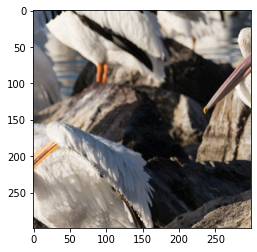

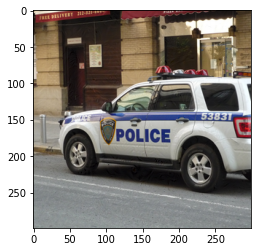

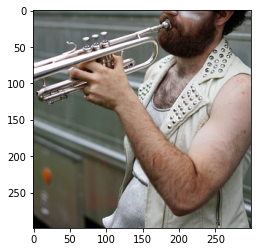

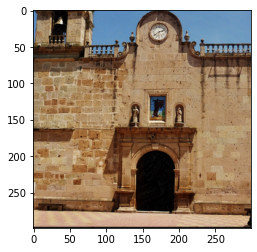

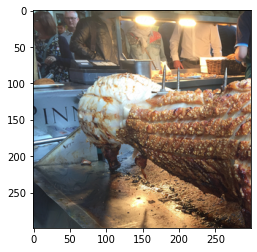

In [ ]:
for i in range(5):
  plt.imshow(X_adv[i].cpu().permute(1,2,0))
  plt.show()

### evaluation on adversarial strength, targetted ( success rate )

In [ ]:
## Evaluation on adversarial strength (success rate)

# batch_size=20
batch_size = 5
num_batches = np.int(np.ceil(len(image_id_list)/batch_size))
cnt=0.
for k in tqdm_notebook(range(0,num_batches)):
    batch_size_cur=min(batch_size,250-k*batch_size)
    X_ori = torch.zeros(batch_size_cur,3,299,299).to(device) 
    X_adv=torch.zeros_like(X_ori)
    for i in range(batch_size_cur): 
        X_ori[i]=trn(Image.open('/content/drive/MyDrive/B20AI023_DAI_Minor_1/dataset/images/'+image_id_list[k*batch_size+i]+'.png'))
        # print(i)
        X_adv[i]=trn(Image.open('/content/drive/MyDrive/B20AI023_DAI_Minor_1/images_adv_PerC_AL/'+image_id_list[k*batch_size+i]+'.png'))
    label_adv=torch.argmax(model((X_adv-0.5)/0.5),dim=1)

#     # untargeted
#     label_ori=torch.argmax(model((X_ori-0.5)/0.5),dim=1)
#     cnt=cnt+torch.sum(label_adv!=label_ori)

    # targeted
    label_tar=torch.tensor(label_tar_list[k*batch_size:k*batch_size+batch_size_cur]).to(device)
    cnt=cnt+torch.sum(label_adv==label_tar)

print(cnt/len(image_id_list))

<ipython-input-7-a456c237768d>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  num_batches = np.int(np.ceil(len(image_id_list)/batch_size))
<ipython-input-7-a456c237768d>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm_notebook(range(0,num_batches)):


  0%|          | 0/50 [00:00<?, ?it/s]

tensor(0., device='cuda:0')


In [ ]:
print(len(image_id_list))

250


In [ ]:
print(cnt.item())

0.0


In [ ]:
success_rate = (1-(cnt.item()/len(image_id_list)))

In [ ]:
print('success rate targetted : ',success_rate*100, '%')

success rate targetted :  100.0 %


###evaluation on adversarial strength, untargetted

In [ ]:
## Evaluation on adversarial strength (success rate)

# batch_size=20
batch_size = 5
num_batches = np.int(np.ceil(len(image_id_list)/batch_size))
cnt=0.
for k in tqdm_notebook(range(0,num_batches)):
    batch_size_cur=min(batch_size,250-k*batch_size)
    X_ori = torch.zeros(batch_size_cur,3,299,299).to(device) 
    X_adv=torch.zeros_like(X_ori)
    for i in range(batch_size_cur): 
        X_ori[i]=trn(Image.open('/content/drive/MyDrive/B20AI023_DAI_Minor_1/dataset/images/'+image_id_list[k*batch_size+i]+'.png'))
        # print(i)
        X_adv[i]=trn(Image.open('/content/drive/MyDrive/B20AI023_DAI_Minor_1/images_adv_PerC_AL/'+image_id_list[k*batch_size+i]+'.png'))
    label_adv=torch.argmax(model((X_adv-0.5)/0.5),dim=1)

    # untargeted
    label_ori=torch.argmax(model((X_ori-0.5)/0.5),dim=1)
    cnt=cnt+torch.sum(label_adv!=label_ori)

    # # targeted
    # label_tar=torch.tensor(label_tar_list[k*batch_size:k*batch_size+batch_size_cur]).to(device)
    # cnt=cnt+torch.sum(label_adv==label_tar)

print(cnt/len(image_id_list))

<ipython-input-12-067c5aa4b1e4>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  num_batches = np.int(np.ceil(len(image_id_list)/batch_size))
<ipython-input-12-067c5aa4b1e4>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm_notebook(range(0,num_batches)):


  0%|          | 0/50 [00:00<?, ?it/s]

tensor(1., device='cuda:0')


In [ ]:
print(cnt)

tensor(250., device='cuda:0')


In [ ]:
success_rate = (cnt.item()/len(image_id_list))

In [ ]:
print('success rate untagetted: ',success_rate*100, '%')

success rate untagetted:  100.0 %


### evaluation on robustness using jpeg compression

In [ ]:
## Evaluation on robustness

def bit_depth_red(X_before,depth):
    r=256/(2**depth)
    x_quan=torch.round(X_before*255/r)*r/255 
    return x_quan

def JPEG_compression(X_before,quality):
        X_after=torch.zeros_like(X_before)
        for j in range(X_after.size(0)):
            x_np=transforms.ToPILImage()(X_before[j].detach().cpu())
            x_np.save('./'+'j.jpg',quality=quality)
            X_after[j]=trn(Image.open('./'+'j.jpg'))
        return X_after
    

# batch_size=50
batch_size =25
num_batches = np.int(np.ceil(len(image_id_list)/batch_size))
levels=[90,80,70,60,50,40,30]#JPEG compression ratios
# levels=[7,6,5,4,3,2]#bit depths 

num=torch.zeros(len(levels))

for k in tqdm_notebook(range(0,num_batches)):
    batch_size_cur=min(batch_size,250-k*batch_size)
    X_ori = torch.zeros(batch_size_cur,3,299,299).to(device) 
    X_adv_before=torch.zeros_like(X_ori)
    for i in range(batch_size_cur): 
        X_ori[i]=trn(Image.open('/content/drive/MyDrive/B20AI023_DAI_Minor_1/dataset/images/'+image_id_list[k*batch_size+i]+'.png'))
        X_adv_before[i]=trn(Image.open('/content/drive/MyDrive/B20AI023_DAI_Minor_1/images_adv_PerC_AL/'+image_id_list[k*batch_size+i]+'.png'))

    label_ori=torch.argmax(model((X_ori-0.5)/0.5),dim=1)
    label_adv_before=torch.argmax(model((X_adv_before-0.5)/0.5),dim=1)

    for i,value in enumerate(levels):
#         X_adv_after=bit_depth_red(X_adv_before,value)
        X_adv_after=JPEG_compression(X_adv_before,value)
        for k in range(1):
            label_after=torch.argmax(model((X_adv_after-0.5)/0.5),dim=1)
            num[i]=num[i]+torch.sum(label_after!=label_ori)

print(num/len(image_id_list))

<ipython-input-16-1170d690361b>:19: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  num_batches = np.int(np.ceil(len(image_id_list)/batch_size))
<ipython-input-16-1170d690361b>:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm_notebook(range(0,num_batches)):


  0%|          | 0/10 [00:00<?, ?it/s]

tensor([0.7440, 0.4640, 0.3440, 0.2480, 0.1960, 0.1720, 0.1640])


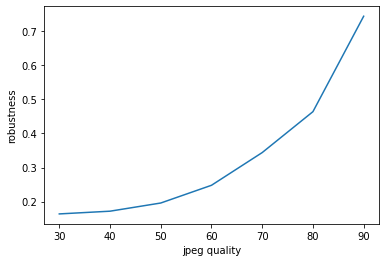

In [ ]:
plt.plot(levels,(num/len(image_id_list)).tolist())
plt.xlabel('jpeg quality')
plt.ylabel('robustness')
plt.show()

### evaluation on robustness using bit depth

In [ ]:
## Evaluation on robustness

def bit_depth_red(X_before,depth):
    r=256/(2**depth)
    x_quan=torch.round(X_before*255/r)*r/255 
    return x_quan

def JPEG_compression(X_before,quality):
        X_after=torch.zeros_like(X_before)
        for j in range(X_after.size(0)):
            x_np=transforms.ToPILImage()(X_before[j].detach().cpu())
            x_np.save('./'+'j.jpg',quality=quality)
            X_after[j]=trn(Image.open('./'+'j.jpg'))
        return X_after
    

# batch_size=50
batch_size =25
num1_batches = np.int(np.ceil(len(image_id_list)/batch_size))
#levels=[90,80,70,60,50,40,30]#JPEG compression ratios
levels=[7,6,5,4,3,2]#bit depths 

num1=torch.zeros(len(levels))

for k in tqdm_notebook(range(0,num1_batches)):
    batch_size_cur=min(batch_size,250-k*batch_size)
    X_ori = torch.zeros(batch_size_cur,3,299,299).to(device) 
    X_adv_before=torch.zeros_like(X_ori)
    for i in range(batch_size_cur): 
        X_ori[i]=trn(Image.open('/content/drive/MyDrive/B20AI023_DAI_Minor_1/dataset/images/'+image_id_list[k*batch_size+i]+'.png'))
        X_adv_before[i]=trn(Image.open('/content/drive/MyDrive/B20AI023_DAI_Minor_1/images_adv_PerC_AL/'+image_id_list[k*batch_size+i]+'.png'))

    label_ori=torch.argmax(model((X_ori-0.5)/0.5),dim=1)
    label_adv_before=torch.argmax(model((X_adv_before-0.5)/0.5),dim=1)

    for i,value in enumerate(levels):
        X_adv_after=bit_depth_red(X_adv_before,value)
        #X_adv_after=JPEG_compression(X_adv_before,value)
        for k in range(1):
            label_after=torch.argmax(model((X_adv_after-0.5)/0.5),dim=1)
            num1[i]=num1[i]+torch.sum(label_after!=label_ori)

print(num1/len(image_id_list))

<ipython-input-18-37c7a03a8099>:19: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  num1_batches = np.int(np.ceil(len(image_id_list)/batch_size))
<ipython-input-18-37c7a03a8099>:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm_notebook(range(0,num1_batches)):


  0%|          | 0/10 [00:00<?, ?it/s]

tensor([1.0000, 0.9960, 0.9480, 0.7760, 0.4640, 0.3320])


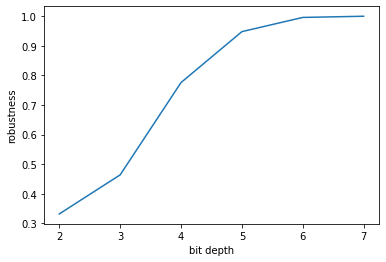

In [ ]:
plt.plot(levels,(num1/len(image_id_list)).tolist())
plt.xlabel('bit depth')
plt.ylabel('robustness')
plt.show()

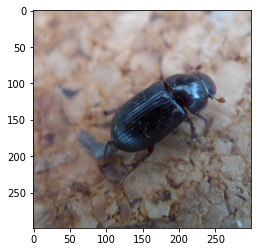

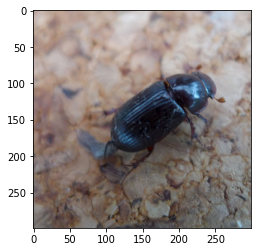

In [ ]:
X_ori = trn(Image.open('/content/drive/MyDrive/B20AI023_DAI_Minor_1/images_adv_PerC_AL/0c7ac4a8c9dfa802.png'))
plt.imshow(X_ori.cpu().permute(1,2,0))
plt.show()
X_adv_after=JPEG_compression(trn(Image.open('/content/drive/MyDrive/B20AI023_DAI_Minor_1/images_adv_PerC_AL/0c7ac4a8c9dfa802.png')),90)
plt.imshow(X_adv_after.cpu().permute(1,2,0))
plt.show()

### Evaluation on tranferability

In [ ]:
model2 = models.googlenet(pretrained=True,transform_input=False).eval()
for param in model2.parameters():
    param.requires_grad=False
device  = torch.device("cuda:0")
model2.to(device)

model3 = models.vgg16_bn(pretrained=True).eval()
for param in model3.parameters():
    param.requires_grad=False
device  = torch.device("cuda:0")
model3.to(device)

model4 = models.resnet152(pretrained=True).eval()
for param in model4.parameters():
    param.requires_grad=False
device  = torch.device("cuda:0")
model4.to(device)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
#find eligible images for tranferability
#batch_size=10
batch_size = 25
num_batches = np.int(np.ceil(len(image_id_list)/batch_size))
eligible_list=[]
for k in tqdm_notebook(range(0,num_batches)):
    batch_size_cur=min(batch_size,len(image_id_list)-k*batch_size)
    X_ori = torch.zeros(batch_size_cur,3,299,299).to(device) 
    for i in range(batch_size_cur): 
        X_ori[i]=trn(Image.open('/content/drive/MyDrive/B20AI023_DAI_Minor_1/dataset/images/'+image_id_list[k*batch_size+i]+'.png'))

    pre_ori_1=torch.argmax(model((X_ori-0.5)/0.5),dim=1)
    pre_ori_2=torch.argmax(model2((X_ori-0.5)/0.5),dim=1)
    pre_ori_3=torch.argmax(model3((X_ori-0.5)/0.5),dim=1)
    pre_ori_4=torch.argmax(model4((X_ori-0.5)/0.5),dim=1)
    mask=((pre_ori_1==pre_ori_2).float() * (pre_ori_1==pre_ori_3).float() * (pre_ori_1==pre_ori_4).float() * (pre_ori_2==pre_ori_3).float() * (pre_ori_2==pre_ori_4).float() * (pre_ori_3==pre_ori_4).float())
    eligible_list.append(mask)
image_transfer_list=[]
for i in range(len(eligible_list)):
    for j in range(batch_size):
        if eligible_list[i][j]==1:
            image_transfer_list.append(image_id_list[i*batch_size+j])

<ipython-input-22-d016f6cb9613>:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  num_batches = np.int(np.ceil(len(image_id_list)/batch_size))
<ipython-input-22-d016f6cb9613>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm_notebook(range(0,num_batches)):


  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
print(eligible_list[:10])
print(len(eligible_list))
print(image_transfer_list[:10])
print(len(image_transfer_list))

[tensor([0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1.,
        0., 0., 0., 1., 0., 0., 0.], device='cuda:0'), tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1.,
        1., 1., 1., 1., 0., 1., 0.], device='cuda:0'), tensor([0., 1., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1.,
        1., 0., 1., 1., 1., 1., 1.], device='cuda:0'), tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
        1., 1., 1., 1., 0., 1., 1.], device='cuda:0'), tensor([1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0.,
        1., 0., 1., 1., 1., 0., 1.], device='cuda:0'), tensor([1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1.,
        1., 1., 0., 0., 1., 0., 1.], device='cuda:0'), tensor([1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0.,
        1., 0., 1., 1., 0., 1., 1.], device='cuda:0'), tensor([0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0.

### transferability

In [ ]:

#calculate tranferability
num_batches = np.int(np.ceil(len(image_transfer_list)/batch_size))
# adv_folder='./images_cw_untar_9000_1_k_40/'
adv_folder = '/content/drive/MyDrive/B20AI023_DAI_Minor_1/images_adv_PerC_AL/'
sr_1=0
sr_2=0
sr_3=0
sr_4=0

for k in tqdm_notebook(range(0,num_batches)):
    batch_size_cur=min(batch_size,len(image_transfer_list)-k*batch_size)
    X_ori = torch.zeros(batch_size_cur,3,299,299).to(device) 
    x_adv = torch.zeros(batch_size_cur,3,299,299).to(device) 
    for i in range(batch_size_cur): 
        X_ori[i]=trn(Image.open('/content/drive/MyDrive/B20AI023_DAI_Minor_1/dataset/images/'+image_transfer_list[k*batch_size+i]+'.png'))
        x_adv[i]=trn(Image.open(adv_folder+image_transfer_list[k*batch_size+i]+'.png'))
        #plt.imshow(X_ori[i].cpu().permute(1,2,0))
        #plt.imshow(x_adv[i].cpu().permute(1,2,0))
        plt.show()
    pre_ori=torch.argmax(model((X_ori-0.5)/0.5),dim=1)
    
    # pre_adv=torch.argmax(model((x_adv-0.5)/0.5),dim=1)
    # pre_adv_2=torch.argmax(model2((x_adv-0.5)/0.5),dim=1)
    # pre_adv_3=torch.argmax(model3(norm(X_ori)),dim=1)
    # pre_adv_4=torch.argmax(model4(norm(X_ori)),dim=1)
    pre_adv=torch.argmax(model((x_adv-0.5)/0.5),dim=1)
    pre_adv_2=torch.argmax(model2((x_adv-0.5)/0.5),dim=1)
    pre_adv_3=torch.argmax(model3((x_adv-0.5)/0.5),dim=1)
    pre_adv_4=torch.argmax(model4((x_adv-0.5)/0.5),dim=1)

    sr_1=sr_1+sum((pre_ori!=pre_adv).float())
    sr_2=sr_2+sum((pre_ori!=pre_adv_2).float())
    sr_3=sr_3+sum((pre_ori!=pre_adv_3).float())
    sr_4=sr_4+sum((pre_ori!=pre_adv_4).float())
print(sr_1/len(image_transfer_list),sr_2/len(image_transfer_list),sr_3/len(image_transfer_list),sr_4/len(image_transfer_list))

<ipython-input-23-c97ad37347d7>:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  num_batches = np.int(np.ceil(len(image_transfer_list)/batch_size))
<ipython-input-23-c97ad37347d7>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm_notebook(range(0,num_batches)):


  0%|          | 0/7 [00:00<?, ?it/s]

tensor(1., device='cuda:0') tensor(0.0517, device='cuda:0') tensor(0.1034, device='cuda:0') tensor(0.0517, device='cuda:0')


In [ ]:
print(sr_1.item())
print(sr_2.item())
print(sr_3.item())
print(sr_4.item())

174.0
9.0
18.0
9.0


In [ ]:
len(image_transfer_list)

174

In [ ]:
print(sr_1.item()/len(image_transfer_list))
print(sr_2.item()/len(image_transfer_list))
print(sr_3.item()/len(image_transfer_list))
print(sr_4.item()/len(image_transfer_list))

1.0
0.05172413793103448
0.10344827586206896
0.05172413793103448


# apply perc_CW

### genereate adversarial images using PerC_CW and save them

In [ ]:
#set the mode (untargeted or targeted)
untargeted=1
batch_size=5
num_batches = np.int(np.ceil(len(image_id_list)/batch_size))
color_differences_cw=[]
l2_norm_cw=[]
l_inf_norm_cw=[]
# output_path='images_adv_PerC_AL'
output_path = '/content/drive/MyDrive/B20AI023_DAI_Minor_1/images_adv_PerC_CW'
if os.path.exists (output_path)==False:
    os.mkdir(output_path)
for k in tqdm_notebook(range(0,num_batches)):
    batch_size_cur=min(batch_size,len(image_id_list)-k*batch_size)
    #load a batch of input images with the size of batch_size*channel*height*width
    X_ori = torch.zeros(batch_size_cur,3,299,299).to(device)    
    for i in range(batch_size_cur):  
        X_ori[i]=trn(Image.open(os.path.join('/content/drive/MyDrive/B20AI023_DAI_Minor_1/dataset/images',image_id_list[k*batch_size+i])+'.png'))  
    X_ori_LAB=rgb2lab_diff(X_ori,device)
    
    if untargeted:
        labels=torch.argmax(model((X_ori-0.5)/0.5),dim=1)
    
    else:
        labels=torch.tensor(label_tar_list[k*batch_size:k*batch_size+batch_size_cur]).to(device)

    approach = PerC_CW(device=device,search_steps=9,max_iterations=1000,learning_rate=0.01,initial_const=10)
    #approach = PerC_AL(device=device,max_iterations=1000,alpha_l_init=1,alpha_c_init=0.5,confidence=40)

    X_adv = approach.adversary(model, X_ori, labels=labels, targeted=False)

    color_distance_map=ciede2000_diff(X_ori_LAB,rgb2lab_diff(X_adv,device),device)   
    #claculate perceptual color_differences_cw, L2 norm and L_inf norm
    color_differences_cw.append(torch.norm(color_distance_map.view(batch_size_cur,-1),dim=1).cpu().numpy())
    l2_norm_cw.append(torch.norm((X_adv-X_ori).view(batch_size_cur,-1),dim=1).cpu().numpy())
    l_inf_norm_cw.append(torch.norm((X_adv-X_ori).view(batch_size_cur,-1),dim=1, p=float('inf')).cpu().numpy())
    
    #save the modified images
    for j in range(batch_size_cur):
        x_np=transforms.ToPILImage()(X_adv[j].detach().cpu())
        x_np.save(os.path.join(output_path,image_id_list[k*batch_size+j])+'.png') 

<ipython-input-62-51ce2bb0aa3c>:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  num_batches = np.int(np.ceil(len(image_id_list)/batch_size))
<ipython-input-62-51ce2bb0aa3c>:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm_notebook(range(0,num_batches)):


  0%|          | 0/50 [00:00<?, ?it/s]

### get the l2_norm, l_inf_norm and color_differences




In [ ]:
print(l2_norm_cw[:10])
print(l_inf_norm_cw[:10])
print(color_differences_cw[:10])

[array([0.22030705, 0.9045318 , 0.5071727 , 0.4385149 , 0.2125621 ],
      dtype=float32), array([0.455223  , 0.78804994, 0.30490038, 0.26847717, 0.45388666],
      dtype=float32), array([0.21974787, 0.8404701 , 0.4937596 , 0.38561213, 0.33157554],
      dtype=float32), array([0.4861006 , 0.0488233 , 1.450774  , 0.59089595, 0.15548417],
      dtype=float32), array([0.67991453, 0.5517161 , 0.3157532 , 0.7474679 , 0.27321824],
      dtype=float32), array([0.3215208 , 0.42494318, 0.4933234 , 1.0030638 , 0.5983574 ],
      dtype=float32), array([0.4167762 , 0.63581437, 0.48541996, 0.33094886, 0.31357843],
      dtype=float32), array([0.39636937, 0.24749422, 0.62151617, 0.45884034, 0.551744  ],
      dtype=float32), array([0.57481426, 0.21689512, 0.7192952 , 0.36634675, 0.5547183 ],
      dtype=float32), array([0.4415032 , 0.483404  , 0.64495206, 0.2648729 , 0.25384402],
      dtype=float32)]
[array([0.01176471, 0.07843138, 0.02352942, 0.02352941, 0.01176476],
      dtype=float32), array([0

In [ ]:
print(len(image_id_list))

250


### sample adversarial images generated using PerC_CW

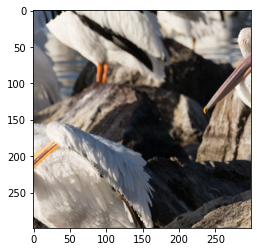

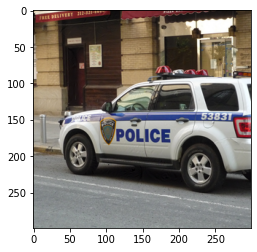

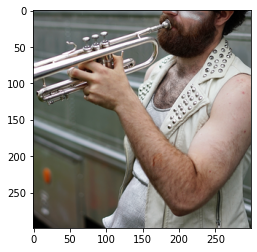

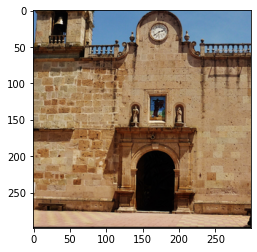

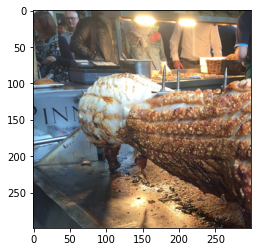

In [ ]:
for i in range(5):
  plt.imshow(X_adv[i].cpu().permute(1,2,0))
  plt.show()

###evaluation on adversarial strength, targeted

In [ ]:
## Evaluation on adversarial strength (success rate)

# batch_size=20
batch_size = 5
num_batches = np.int(np.ceil(len(image_id_list)/batch_size))
cnt=0.
for k in tqdm_notebook(range(0,num_batches)):
    batch_size_cur=min(batch_size,250-k*batch_size)
    X_ori = torch.zeros(batch_size_cur,3,299,299).to(device) 
    X_adv=torch.zeros_like(X_ori)
    for i in range(batch_size_cur): 
        X_ori[i]=trn(Image.open('/content/drive/MyDrive/B20AI023_DAI_Minor_1/dataset/images/'+image_id_list[k*batch_size+i]+'.png'))
        # print(i)
        X_adv[i]=trn(Image.open('/content/drive/MyDrive/B20AI023_DAI_Minor_1/images_adv_PerC_CW/'+image_id_list[k*batch_size+i]+'.png'))
    label_adv=torch.argmax(model((X_adv-0.5)/0.5),dim=1)

#     # untargeted
#     label_ori=torch.argmax(model((X_ori-0.5)/0.5),dim=1)
#     cnt=cnt+torch.sum(label_adv!=label_ori)

    # targeted
    label_tar=torch.tensor(label_tar_list[k*batch_size:k*batch_size+batch_size_cur]).to(device)
    cnt=cnt+torch.sum(label_adv==label_tar)

print(cnt/len(image_id_list))

<ipython-input-125-8efba0ad6615>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  num_batches = np.int(np.ceil(len(image_id_list)/batch_size))
<ipython-input-125-8efba0ad6615>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm_notebook(range(0,num_batches)):


  0%|          | 0/50 [00:00<?, ?it/s]

tensor(0., device='cuda:0')


In [ ]:
print(cnt.item())

0.0


In [ ]:
success_rate = 1 - (cnt.item()/len(image_id_list))
print('success rate targetted:', success_rate*100, '%')

success rate targetted: 100.0 %


###evaluation on adversarial strength, untargeted

In [ ]:
## Evaluation on adversarial strength (success rate)

# batch_size=20
batch_size = 5
num_batches = np.int(np.ceil(len(image_id_list)/batch_size))
cnt=0.
for k in tqdm_notebook(range(0,num_batches)):
    batch_size_cur=min(batch_size,250-k*batch_size)
    X_ori = torch.zeros(batch_size_cur,3,299,299).to(device) 
    X_adv=torch.zeros_like(X_ori)
    for i in range(batch_size_cur): 
        X_ori[i]=trn(Image.open('/content/drive/MyDrive/B20AI023_DAI_Minor_1/dataset/images/'+image_id_list[k*batch_size+i]+'.png'))
        # print(i)
        X_adv[i]=trn(Image.open('/content/drive/MyDrive/B20AI023_DAI_Minor_1/images_adv_PerC_CW/'+image_id_list[k*batch_size+i]+'.png'))
    label_adv=torch.argmax(model((X_adv-0.5)/0.5),dim=1)

    # untargeted
    label_ori=torch.argmax(model((X_ori-0.5)/0.5),dim=1)
    cnt=cnt+torch.sum(label_adv!=label_ori)

    # # targeted
    # label_tar=torch.tensor(label_tar_list[k*batch_size:k*batch_size+batch_size_cur]).to(device)
    # cnt=cnt+torch.sum(label_adv==label_tar)

print(cnt/len(image_id_list))

<ipython-input-128-1640ffa1794a>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  num_batches = np.int(np.ceil(len(image_id_list)/batch_size))
<ipython-input-128-1640ffa1794a>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm_notebook(range(0,num_batches)):


  0%|          | 0/50 [00:00<?, ?it/s]

tensor(1., device='cuda:0')


In [ ]:
success_rate = (cnt.item()/len(image_id_list))
print('success rate untargetted:', success_rate*100, '%')

success rate untargetted: 100.0 %


### robustenss based on jpeg compression

In [ ]:
## Evaluation on robustness

def bit_depth_red(X_before,depth):
    r=256/(2**depth)
    x_quan=torch.round(X_before*255/r)*r/255 
    return x_quan

def JPEG_compression(X_before,quality):
        X_after=torch.zeros_like(X_before)
        for j in range(X_after.size(0)):
            x_np=transforms.ToPILImage()(X_before[j].detach().cpu())
            x_np.save('./'+'j.jpg',quality=quality)
            X_after[j]=trn(Image.open('./'+'j.jpg'))
        return X_after
    

# batch_size=50
batch_size =25
num2_batches = np.int(np.ceil(len(image_id_list)/batch_size))
levels=[90,80,70,60,50,40,30]#JPEG compression ratios
# levels=[7,6,5,4,3,2]#bit depths 

num2=torch.zeros(len(levels))

for k in tqdm_notebook(range(0,num2_batches)):
    batch_size_cur=min(batch_size,250-k*batch_size)
    X_ori = torch.zeros(batch_size_cur,3,299,299).to(device) 
    X_adv_before=torch.zeros_like(X_ori)
    for i in range(batch_size_cur): 
        X_ori[i]=trn(Image.open('/content/drive/MyDrive/B20AI023_DAI_Minor_1/dataset/images/'+image_id_list[k*batch_size+i]+'.png'))
        X_adv_before[i]=trn(Image.open('/content/drive/MyDrive/B20AI023_DAI_Minor_1/images_adv_PerC_CW/'+image_id_list[k*batch_size+i]+'.png'))

    label_ori=torch.argmax(model((X_ori-0.5)/0.5),dim=1)
    label_adv_before=torch.argmax(model((X_adv_before-0.5)/0.5),dim=1)

    for i,value in enumerate(levels):
#         X_adv_after=bit_depth_red(X_adv_before,value)
        X_adv_after=JPEG_compression(X_adv_before,value)
        for k in range(1):
            label_after=torch.argmax(model((X_adv_after-0.5)/0.5),dim=1)
            num2[i]=num2[i]+torch.sum(label_after!=label_ori)

print(num2/len(image_id_list))

<ipython-input-39-17d89b3c5610>:19: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  num2_batches = np.int(np.ceil(len(image_id_list)/batch_size))
<ipython-input-39-17d89b3c5610>:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm_notebook(range(0,num2_batches)):


  0%|          | 0/10 [00:00<?, ?it/s]

tensor([0.0400, 0.0440, 0.0640, 0.0520, 0.0520, 0.0760, 0.0960])


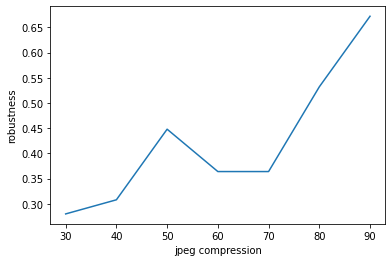

In [ ]:
plt.plot(levels,(Num2/len(image_id_list)).tolist())
plt.xlabel('jpeg compression')
plt.ylabel('robustness')
plt.show()

### robustenss based on bit depths

In [ ]:
## Evaluation on robustness

def bit_depth_red(X_before,depth):
    r=256/(2**depth)
    x_quan=torch.round(X_before*255/r)*r/255 
    return x_quan

def JPEG_compression(X_before,quality):
        X_after=torch.zeros_like(X_before)
        for j in range(X_after.size(0)):
            x_np=transforms.ToPILImage()(X_before[j].detach().cpu())
            x_np.save('./'+'j.jpg',quality=quality)
            X_after[j]=trn(Image.open('./'+'j.jpg'))
        return X_after
    

# batch_size=50
batch_size =25
num3_batches = np.int(np.ceil(len(image_id_list)/batch_size))
#levels=[90,80,70,60,50,40,30]#JPEG compression ratios
levels=[7,6,5,4,3,2]#bit depths 

num3=torch.zeros(len(levels))

for k in tqdm_notebook(range(0,num3_batches)):
    batch_size_cur=min(batch_size,250-k*batch_size)
    X_ori = torch.zeros(batch_size_cur,3,299,299).to(device) 
    X_adv_before=torch.zeros_like(X_ori)
    for i in range(batch_size_cur): 
        X_ori[i]=trn(Image.open('/content/drive/MyDrive/B20AI023_DAI_Minor_1/dataset/images/'+image_id_list[k*batch_size+i]+'.png'))
        X_adv_before[i]=trn(Image.open('/content/drive/MyDrive/B20AI023_DAI_Minor_1/images_adv_PerC_CW/'+image_id_list[k*batch_size+i]+'.png'))

    label_ori=torch.argmax(model((X_ori-0.5)/0.5),dim=1)
    label_adv_before=torch.argmax(model((X_adv_before-0.5)/0.5),dim=1)

    for i,value in enumerate(levels):
        X_adv_after=bit_depth_red(X_adv_before,value)
        #X_adv_after=JPEG_compression(X_adv_before,value)
        for k in range(1):
            label_after=torch.argmax(model((X_adv_after-0.5)/0.5),dim=1)
            num3[i]=num3[i]+torch.sum(label_after!=label_ori)

print(num3/len(image_id_list))

<ipython-input-43-a0be01ba7883>:19: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  num3_batches = np.int(np.ceil(len(image_id_list)/batch_size))
<ipython-input-43-a0be01ba7883>:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm_notebook(range(0,num3_batches)):


  0%|          | 0/10 [00:00<?, ?it/s]

tensor([0.3480, 0.2160, 0.0640, 0.0720, 0.0800, 0.2040])


In [ ]:
print

tensor([250., 249., 237., 194., 116.,  83.])


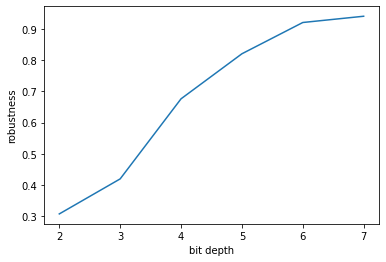

In [ ]:
plt.plot(levels,(Num3/len(image_id_list)).tolist())
plt.xlabel('bit depth')
plt.ylabel('robustness')
plt.show()

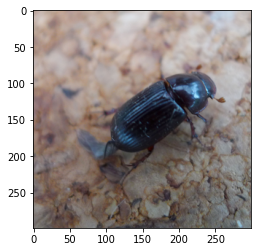

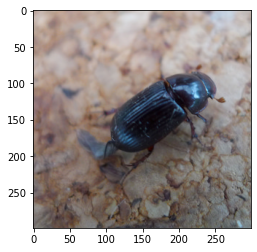

In [ ]:
X_ori = trn(Image.open('/content/drive/MyDrive/B20AI023_DAI_Minor_1/images_adv_PerC_CW/0c7ac4a8c9dfa802.png'))
plt.imshow(X_ori.cpu().permute(1,2,0))
plt.show()
X_adv_after=JPEG_compression(trn(Image.open('/content/drive/MyDrive/B20AI023_DAI_Minor_1/images_adv_PerC_CW/0c7ac4a8c9dfa802.png')),90)
plt.imshow(X_adv_after.cpu().permute(1,2,0))
plt.show()

## Evaluation on tranferability

In [ ]:
model2 = models.googlenet(pretrained=True,transform_input=False).eval()
for param in model2.parameters():
    param.requires_grad=False
device  = torch.device("cuda:0")
model2.to(device)

model3 = models.vgg16_bn(pretrained=True).eval()
for param in model3.parameters():
    param.requires_grad=False
device  = torch.device("cuda:0")
model3.to(device)

model4 = models.resnet152(pretrained=True).eval()
for param in model4.parameters():
    param.requires_grad=False
device  = torch.device("cuda:0")
model4.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
#find eligible images for tranferability
#batch_size=10
batch_size = 25
num_batches = np.int(np.ceil(len(image_id_list)/batch_size))
eligible_list2=[]
for k in tqdm_notebook(range(0,num_batches)):
    batch_size_cur=min(batch_size,len(image_id_list)-k*batch_size)
    X_ori = torch.zeros(batch_size_cur,3,299,299).to(device) 
    for i in range(batch_size_cur): 
        X_ori[i]=trn(Image.open('/content/drive/MyDrive/B20AI023_DAI_Minor_1/dataset/images/'+image_id_list[k*batch_size+i]+'.png'))

    pre_ori_1=torch.argmax(model((X_ori-0.5)/0.5),dim=1)
    pre_ori_2=torch.argmax(model2((X_ori-0.5)/0.5),dim=1)
    pre_ori_3=torch.argmax(model3(norm(X_ori)),dim=1)
    pre_ori_4=torch.argmax(model4(norm(X_ori)),dim=1)
    mask=((pre_ori_1==pre_ori_2).float() * (pre_ori_1==pre_ori_3).float() * (pre_ori_1==pre_ori_4).float() * (pre_ori_2==pre_ori_3).float() * (pre_ori_2==pre_ori_4).float() * (pre_ori_3==pre_ori_4).float())
    eligible_list2.append(mask)
image_transfer_list2=[]
for i in range(len(eligible_list2)):
    for j in range(batch_size):
        if eligible_list2[i][j]==1:
            image_transfer_list2.append(image_id_list[i*batch_size+j])

<ipython-input-139-4403d427291b>:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  num_batches = np.int(np.ceil(len(image_id_list)/batch_size))
<ipython-input-139-4403d427291b>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm_notebook(range(0,num_batches)):


  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
print(eligible_list2[:10])
print(len(eligible_list2))
print(image_transfer_list2[:10])
print(len(image_transfer_list2))

[tensor([1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 1., 1., 0., 0.], device='cuda:0'), tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1.,
        1., 1., 0., 1., 0., 1., 0.], device='cuda:0'), tensor([0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 0., 1., 1., 1., 1., 1.], device='cuda:0'), tensor([1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
        1., 1., 1., 1., 0., 1., 1.], device='cuda:0'), tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0.,
        1., 0., 1., 1., 1., 0., 1.], device='cuda:0'), tensor([1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
        1., 1., 1., 0., 1., 0., 1.], device='cuda:0'), tensor([1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
        0., 0., 1., 1., 1., 1., 0.], device='cuda:0'), tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.

### transferability

In [ ]:

#calculate tranferability
num_batches = np.int(np.ceil(len(image_transfer_list)/batch_size))
# adv_folder='./images_cw_untar_9000_1_k_40/'
adv_folder = '/content/drive/MyDrive/B20AI023_DAI_Minor_1/images_adv_PerC_CW/'
sr_1_cw=0
sr_2_cw=0
sr_3_cw=0
sr_4_cw=0

for k in tqdm_notebook(range(0,num_batches)):
    batch_size_cur=min(batch_size,len(image_transfer_list)-k*batch_size)
    X_ori = torch.zeros(batch_size_cur,3,299,299).to(device) 
    x_adv = torch.zeros(batch_size_cur,3,299,299).to(device) 
    for i in range(batch_size_cur): 
        X_ori[i]=trn(Image.open('/content/drive/MyDrive/B20AI023_DAI_Minor_1/dataset/images/'+image_transfer_list[k*batch_size+i]+'.png'))
        x_adv[i]=trn(Image.open(adv_folder+image_transfer_list[k*batch_size+i]+'.png'))
        #plt.imshow(X_ori[i].cpu().permute(1,2,0))
        #plt.imshow(x_adv[i].cpu().permute(1,2,0))
        plt.show()
    pre_ori=torch.argmax(model((X_ori-0.5)/0.5),dim=1)
    pre_adv=torch.argmax(model((x_adv-0.5)/0.5),dim=1)
    pre_adv_2=torch.argmax(model2((x_adv-0.5)/0.5),dim=1)
    pre_adv_3=torch.argmax(model3(norm(X_ori)),dim=1)
    pre_adv_4=torch.argmax(model4(norm(X_ori)),dim=1)
    
    
    sr_1_cw=sr_1_cw+sum((pre_ori!=pre_adv).float())
    sr_2_cw=sr_2_cw+sum((pre_ori!=pre_adv_2).float())
    sr_3_cw=sr_3_cw+sum((pre_ori!=pre_adv_3).float())
    sr_4_cw=sr_4_cw+sum((pre_ori!=pre_adv_4).float())
print(sr_1_cw/len(image_transfer_list),sr_2_cw/len(image_transfer_list),sr_3_cw/len(image_transfer_list),sr_4_cw/len(image_transfer_list))

<ipython-input-37-62d361711bad>:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  num_batches = np.int(np.ceil(len(image_transfer_list)/batch_size))
<ipython-input-37-62d361711bad>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm_notebook(range(0,num_batches)):


  0%|          | 0/7 [00:00<?, ?it/s]

tensor(1., device='cuda:0') tensor(0.0115, device='cuda:0') tensor(0.0345, device='cuda:0') tensor(0.0172, device='cuda:0')


In [ ]:
print(sr_1_cw.item())
print(sr_2_cw.item())
print(sr_3_cw.item())
print(sr_4_cw.item())

174.0
2.0
6.0
3.0


In [ ]:
print(sr_1_cw.item()/len(image_transfer_list))
print(sr_2_cw.item()/len(image_transfer_list))
print(sr_3_cw.item()/len(image_transfer_list))
print(sr_4_cw.item()/len(image_transfer_list))

1.0
0.011494252873563218
0.034482758620689655
0.017241379310344827


## plots

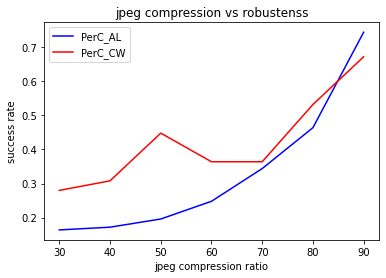

In [ ]:
plt.plot([90,80,70,60,50,40,30],num/len(image_id_list), 'b-', label ='PerC_AL')
plt.plot([90,80,70,60,50,40,30],num2/len(image_id_list), 'r-', label = 'PerC_CW')
plt.xlabel('jpeg compression ratio')
plt.ylabel('success rate')
plt.legend()
plt.title('jpeg compression vs robustenss')
plt.show()

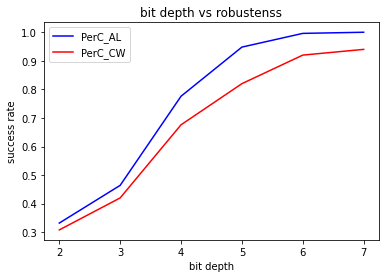

In [ ]:
plt.plot([7,6,5,4,3,2],num1/len(image_id_list), 'b-', label ='PerC_AL')
plt.plot([7,6,5,4,3,2],num3/len(image_id_list), 'r-', label = 'PerC_CW')
plt.xlabel('bit depth')
plt.ylabel('success rate')
plt.legend()
plt.title('bit depth vs robustenss')
plt.show()

In [ ]:
original = []
x_perc_al = []
x_perc_cw = []
for i in image_id_list[:7]:  
    original.append(trn(Image.open(os.path.join('/content/drive/MyDrive/B20AI023_DAI_Minor_1/dataset/images',i)+'.png')))
    x_perc_al.append(trn(Image.open('/content/drive/MyDrive/B20AI023_DAI_Minor_1/images_adv_PerC_AL/'+i+'.png')))
    x_perc_cw.append(trn(Image.open('/content/drive/MyDrive/B20AI023_DAI_Minor_1/images_adv_PerC_CW/'+i+'.png')))

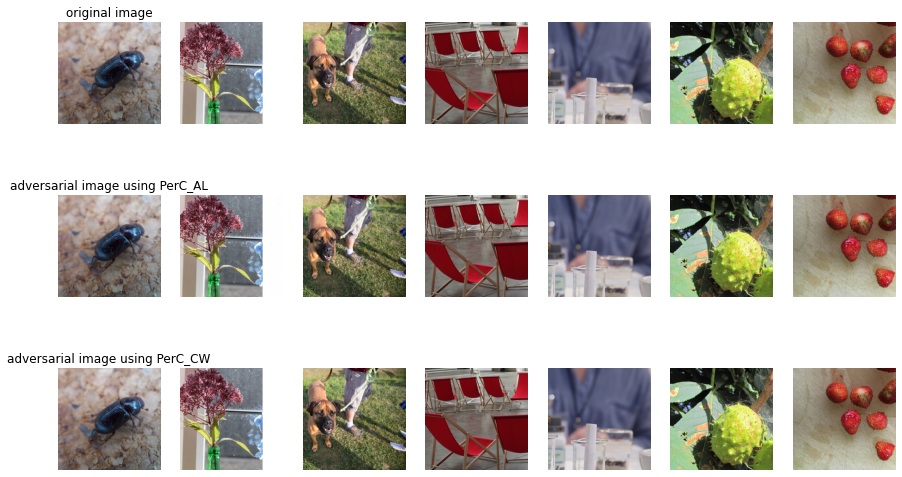

In [ ]:
fig, axs = plt.subplots(3, 7, figsize=(15, 9))

# Iterate over each image in the lists and plot them on the subplots
for i in range(7):
    axs[0, i].imshow(original[i].permute(1, 2, 0).cpu().numpy())
    axs[0, i].axis('off')
    axs[1, i].imshow(x_perc_al[i].permute(1, 2, 0).cpu().numpy())
    axs[1, i].axis('off')
    axs[2, i].imshow(x_perc_cw[i].permute(1, 2, 0).cpu().numpy())
    axs[2, i].axis('off')

# Set the title of each row
axs[0, 0].set_title('original image')
axs[1, 0].set_title('adversarial image using PerC_AL')
axs[2, 0].set_title('adversarial image using PerC_CW')

# Display the figure
plt.show()

## applying on new dataset : visual genome

In [ ]:
def load_url(csv_filename):
    # image_id_list = []
    # label_tar_list = []
    image_url_list = []

    with open(csv_filename) as csvfile:
        reader = csv.DictReader(csvfile, delimiter=',')
        for row in reader:
            # image_id_list.append( row['ImageId'] )
            # label_tar_list.append( int(row['TargetClass'])-1 )
            # print(row)
            image_url_list.append( row['url'].replace(" ", "") )

    return image_url_list

In [ ]:
#load image urls
image_url_list=load_url('/content/drive/MyDrive/B20AI023_DAI_Minor_1/dataset/visual_genome_dataset.csv')
  
device  = torch.device("cuda:0")
# load the pre-trained model
model = models.inception_v3(pretrained=True,transform_input=False).eval()
for param in model.parameters():
    param.requires_grad=False
model.to(device)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [ ]:
image_url_list1 = image_url_list[:50]

In [ ]:
from urllib.request import urlopen
from io import BytesIO
from PIL import Image

###applying PerC_AL

In [ ]:
#set the mode (untargeted or targeted)
untargeted=1
batch_size=5
num_batches = np.int(np.ceil(len(image_url_list1)/batch_size))
color_differences3=[]
l2_norm3=[]
l_inf_norm3=[]
# output_path='images_adv_PerC_AL'
output_path = '/content/drive/MyDrive/B20AI023_DAI_Minor_1/visual_genome_perc_al'
if os.path.exists (output_path)==False:
    os.mkdir(output_path)

counter=1
for k in tqdm_notebook(range(0,num_batches)):
    batch_size_cur=batch_size
    #load a batch of input images with the size of batch_size*channel*height*width
    X_ori = torch.zeros(batch_size_cur,3,299,299).to(device)    
    for i in range(batch_size_cur):  
        # open the image using its URL
        url = image_url_list1[k*batch_size+i]
        # print(url)
        with urlopen(url) as url_response:
            image_data = url_response.read()
        X_ori[i]=trn(Image.open(BytesIO(image_data)).resize((299, 299)))  
    X_ori_LAB=rgb2lab_diff(X_ori,device)
    
    labels=torch.argmax(model((X_ori-0.5)/0.5),dim=1)
    

#     approach = PerC_CW(device=device,search_steps=9,max_iterations=1000,learning_rate=0.01,initial_const=10)
    approach = PerC_AL(device=device,max_iterations=1000,alpha_l_init=1,alpha_c_init=0.5,confidence=40)

    X_adv = approach.adversary(model, X_ori, labels=labels, targeted=False)

    color_distance_map=ciede2000_diff(X_ori_LAB,rgb2lab_diff(X_adv,device),device)   
    #claculate perceptual color_differences3, L2 norm and L_inf norm
    color_differences3.append(torch.norm(color_distance_map.view(batch_size_cur,-1),dim=1).cpu().numpy())
    l2_norm3.append(torch.norm((X_adv-X_ori).view(batch_size_cur,-1),dim=1).cpu().numpy())
    l_inf_norm3.append(torch.norm((X_adv-X_ori).view(batch_size_cur,-1),dim=1, p=float('inf')).cpu().numpy())
    
    #save the modified images
    for j in range(batch_size_cur):
        x_np=transforms.ToPILImage()(X_adv[j].detach().cpu())
        x_np.save(os.path.join(output_path,str(counter)+'.jpg'))
        counter+=1 

<ipython-input-59-739434eb6de2>:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  num_batches = np.int(np.ceil(len(image_url_list1)/batch_size))
<ipython-input-59-739434eb6de2>:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm_notebook(range(0,num_batches)):


  0%|          | 0/10 [00:00<?, ?it/s]

<ipython-input-4-a20efbb24274>:99: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  delta.data[~mask_isadv]=delta.data[~mask_isadv]+alpha_l*(grad_a.permute(1,2,3,0)/torch.norm(grad_a.view(batch_size,-1),dim=1)).permute(3,0,1,2)[~mask_isadv]
<ipython-input-4-a20efbb24274>:106: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  delta.data[mask_isadv]=delta.data[mask_isadv]-alpha_c* (grad_color.permute(1,2,3,0)/torch.norm(grad_color.view(batch_size,-1),dim=1)).permute(3,0,1,2)[mask_isadv]


### get the l2_norm, l_inf_norm and color_diffrences

In [ ]:
print(l2_norm3[:10])
print(l_inf_norm3[:10])
print(color_differences3[:10])

[array([1.4871279, 1.9797977, 1.9622194, 2.1607237, 1.5468489],
      dtype=float32), array([1.7289717, 1.6276448, 1.3748329, 1.4790028, 2.05203  ],
      dtype=float32), array([1.6158813, 2.2647557, 1.8073499, 3.645701 , 2.1073935],
      dtype=float32), array([1.8461509, 1.5442367, 1.7844213, 1.4248792, 1.7323307],
      dtype=float32), array([1.6847099, 2.7368863, 2.1351342, 1.6346402, 2.280307 ],
      dtype=float32), array([2.5326948, 1.849763 , 2.0202734, 2.1145003, 1.969674 ],
      dtype=float32), array([2.5648198, 1.8921682, 2.1556318, 2.0656881, 1.2924352],
      dtype=float32), array([2.513281 , 1.7088865, 1.2636703, 1.6514368, 2.1663427],
      dtype=float32), array([1.6221793, 1.6303306, 1.8551427, 1.726172 , 2.2340207],
      dtype=float32), array([2.6505222, 2.3806882, 2.6918275, 2.0698926, 1.454051 ],
      dtype=float32)]
[array([0.15294118, 0.14509805, 0.20784314, 0.14117648, 0.09803922],
      dtype=float32), array([0.10980392, 0.16862746, 0.04705882, 0.07843138, 0.1

### some adversarial images of this dataset

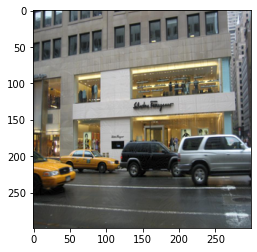

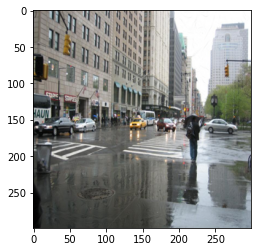

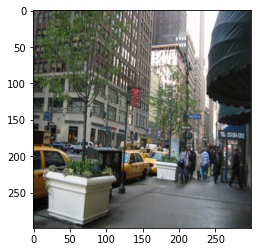

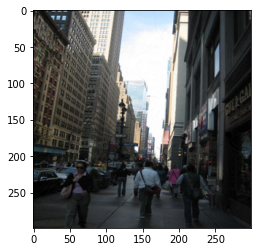

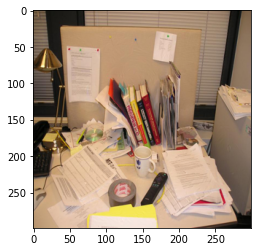

In [ ]:
for i in range(5):
  plt.imshow(X_adv[i].cpu().permute(1,2,0))
  plt.show()

### evaluation on adversarial strength, untargetted ( success rate )

In [ ]:
## Evaluation on adversarial strength (success rate)

# batch_size=20
batch_size = 5
num_batches = np.int(np.ceil(len(image_url_list1)/batch_size))
cnt=0.

counter=1
for k in tqdm_notebook(range(0,num_batches)):
    batch_size_cur=batch_size
    X_ori = torch.zeros(batch_size_cur,3,299,299).to(device) 
    X_adv=torch.zeros_like(X_ori)
    for i in range(batch_size_cur):
        # open the image using its URL
        url = image_url_list1[k*batch_size+i]
        # print(url)
        with urlopen(url) as url_response:
            image_data = url_response.read() 
        X_ori[i]=trn(Image.open(BytesIO(image_data)).resize((299, 299)))
        # print(i)
        X_adv[i]=trn(Image.open('/content/drive/MyDrive/B20AI023_DAI_Minor_1/visual_genome_perc_al/'+str(counter)+'.jpg').resize((299, 299)))
        counter+=1
    label_adv=torch.argmax(model((X_adv-0.5)/0.5),dim=1)

    # untargeted
    label_ori=torch.argmax(model((X_ori-0.5)/0.5),dim=1)
    cnt=cnt+torch.sum(label_adv!=label_ori)

    # targeted
    # label_tar=torch.tensor(label_tar_list[k*batch_size:k*batch_size+batch_size_cur]).to(device)
    # cnt=cnt+torch.sum(label_adv==label_tar)

print(cnt/len(image_url_list1))

<ipython-input-62-7927783de1f4>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  num_batches = np.int(np.ceil(len(image_url_list1)/batch_size))
<ipython-input-62-7927783de1f4>:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm_notebook(range(0,num_batches)):


  0%|          | 0/10 [00:00<?, ?it/s]

tensor(0.7000, device='cuda:0')


In [ ]:
print(len(image_url_list1))

50


In [ ]:
print(cnt.item())

35.0


In [ ]:
success_rate = cnt.item()/len(image_url_list1)

In [ ]:
print('success rate untargetted : ',success_rate*100, '%')

success rate untargetted :  70.0 %


### evaluation on robustness using jpeg compression

In [ ]:
## Evaluation on robustness

def bit_depth_red(X_before,depth):
    r=256/(2**depth)
    x_quan=torch.round(X_before*255/r)*r/255 
    return x_quan

def JPEG_compression(X_before,quality):
        X_after=torch.zeros_like(X_before)
        for j in range(X_after.size(0)):
            x_np=transforms.ToPILImage()(X_before[j].detach().cpu())
            x_np.save('./'+'j.jpg',quality=quality)
            X_after[j]=trn(Image.open('./'+'j.jpg'))
        return X_after
    

# batch_size=50
batch_size = 5
num_batches = np.int(np.ceil(len(image_url_list1)/batch_size))
levels=[90,80,70,60,50,40,30]#JPEG compression ratios
# levels=[7,6,5,4,3,2]#bit depths 

num5=torch.zeros(len(levels))

counter=1
for k in tqdm_notebook(range(0,num_batches)):
    batch_size_cur=batch_size
    X_ori = torch.zeros(batch_size_cur,3,299,299).to(device) 
    X_adv_before=torch.zeros_like(X_ori)
    for i in range(batch_size_cur):
        # open the image using its URL
        url = image_url_list1[k*batch_size+i]
        # print(url)
        with urlopen(url) as url_response:
            image_data = url_response.read() 
        X_ori[i]=trn(Image.open(BytesIO(image_data)).resize((299, 299)))
        X_adv_before[i]=trn(Image.open('/content/drive/MyDrive/B20AI023_DAI_Minor_1/visual_genome_perc_al/'+str(counter)+'.jpg').resize((299, 299)))
        counter+=1

    label_ori=torch.argmax(model((X_ori-0.5)/0.5),dim=1)
    label_adv_before=torch.argmax(model((X_adv_before-0.5)/0.5),dim=1)

    for i,value in enumerate(levels):
#         X_adv_after=bit_depth_red(X_adv_before,value)
        X_adv_after=JPEG_compression(X_adv_before,value)
        for k in range(1):
            label_after=torch.argmax(model((X_adv_after-0.5)/0.5),dim=1)
            num5[i]=num5[i]+torch.sum(label_after!=label_ori)

print(num5/len(image_url_list1))

<ipython-input-67-20b241d6abb3>:19: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  num_batches = np.int(np.ceil(len(image_url_list1)/batch_size))
<ipython-input-67-20b241d6abb3>:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm_notebook(range(0,num_batches)):


  0%|          | 0/10 [00:00<?, ?it/s]

tensor([0.7400, 0.6800, 0.7000, 0.7200, 0.5600, 0.4600, 0.4600])


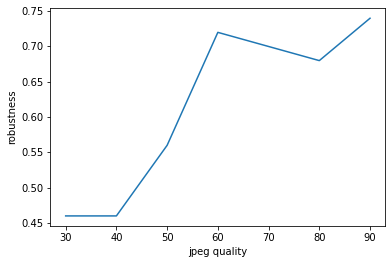

In [ ]:
plt.plot(levels,(num5/len(image_url_list1)).tolist())
plt.xlabel('jpeg quality')
plt.ylabel('robustness')
plt.show()

### evaluation on robustness using bit depth

In [ ]:
## Evaluation on robustness

def bit_depth_red(X_before,depth):
    r=256/(2**depth)
    x_quan=torch.round(X_before*255/r)*r/255 
    return x_quan

def JPEG_compression(X_before,quality):
        X_after=torch.zeros_like(X_before)
        for j in range(X_after.size(0)):
            x_np=transforms.ToPILImage()(X_before[j].detach().cpu())
            x_np.save('./'+'j.jpg',quality=quality)
            X_after[j]=trn(Image.open('./'+'j.jpg'))
        return X_after
    

# batch_size=50
batch_size =5
num1_batches = np.int(np.ceil(len(image_url_list1)/batch_size))
#levels=[90,80,70,60,50,40,30]#JPEG compression ratios
levels=[7,6,5,4,3,2]#bit depths 

num6=torch.zeros(len(levels))

counter=1
for k in tqdm_notebook(range(0,num1_batches)):
    batch_size_cur=batch_size
    X_ori = torch.zeros(batch_size_cur,3,299,299).to(device) 
    X_adv_before=torch.zeros_like(X_ori)
    for i in range(batch_size_cur):
        # open the image using its URL
        url = image_url_list1[k*batch_size+i]
        # print(url)
        with urlopen(url) as url_response:
            image_data = url_response.read()  
        X_ori[i]=trn(Image.open(BytesIO(image_data)).resize((299, 299)))
        X_adv_before[i]=trn(Image.open('/content/drive/MyDrive/B20AI023_DAI_Minor_1/visual_genome_perc_al/'+str(counter)+'.jpg').resize((299, 299)))
        counter+=1

    label_ori=torch.argmax(model((X_ori-0.5)/0.5),dim=1)
    label_adv_before=torch.argmax(model((X_adv_before-0.5)/0.5),dim=1)

    for i,value in enumerate(levels):
        X_adv_after=bit_depth_red(X_adv_before,value)
        #X_adv_after=JPEG_compression(X_adv_before,value)
        for k in range(1):
            label_after=torch.argmax(model((X_adv_after-0.5)/0.5),dim=1)
            num6[i]=num6[i]+torch.sum(label_after!=label_ori)

print(num6/len(image_url_list1))

<ipython-input-69-5add99b2cde0>:19: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  num1_batches = np.int(np.ceil(len(image_url_list1)/batch_size))
<ipython-input-69-5add99b2cde0>:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm_notebook(range(0,num1_batches)):


  0%|          | 0/10 [00:00<?, ?it/s]

tensor([0.7200, 0.7200, 0.7200, 0.6600, 0.6000, 0.6000])


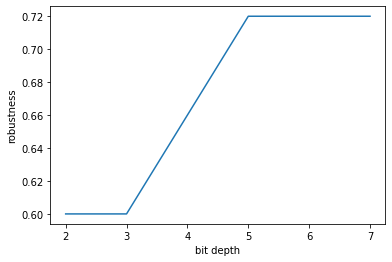

In [ ]:
plt.plot(levels,(num6/len(image_url_list1)).tolist())
plt.xlabel('bit depth')
plt.ylabel('robustness')
plt.show()

### Evaluation on tranferability

In [ ]:
model2 = models.googlenet(pretrained=True,transform_input=False).eval()
for param in model2.parameters():
    param.requires_grad=False
device  = torch.device("cuda:0")
model2.to(device)

model3 = models.vgg16_bn(pretrained=True).eval()
for param in model3.parameters():
    param.requires_grad=False
device  = torch.device("cuda:0")
model3.to(device)

model4 = models.resnet152(pretrained=True).eval()
for param in model4.parameters():
    param.requires_grad=False
device  = torch.device("cuda:0")
model4.to(device)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weigh

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
#find eligible images for tranferability
#batch_size=10
batch_size = 5
num_batches = np.int(np.ceil(len(image_url_list1)/batch_size))
eligible_list_vg=[]
for k in tqdm_notebook(range(0,num_batches)):
    batch_size_cur=batch_size
    X_ori = torch.zeros(batch_size_cur,3,299,299).to(device) 
    for i in range(batch_size_cur): 
        # open the image using its URL
        url = image_url_list1[k*batch_size+i]
        # print(url)
        with urlopen(url) as url_response:
            image_data = url_response.read()  
        X_ori[i]=trn(Image.open(BytesIO(image_data)).resize((299, 299)))

    pre_ori_1=torch.argmax(model((X_ori-0.5)/0.5),dim=1)
    pre_ori_2=torch.argmax(model2((X_ori-0.5)/0.5),dim=1)
    pre_ori_3=torch.argmax(model3(norm(X_ori)),dim=1)
    pre_ori_4=torch.argmax(model4(norm(X_ori)),dim=1)
    mask=((pre_ori_1==pre_ori_2).float() * (pre_ori_1==pre_ori_3).float() * (pre_ori_1==pre_ori_4).float() * (pre_ori_2==pre_ori_3).float() * (pre_ori_2==pre_ori_4).float() * (pre_ori_3==pre_ori_4).float())
    eligible_list_vg.append(mask)
image_transfer_list_vg=[]
for i in range(len(eligible_list_vg)):
    for j in range(batch_size):
        if eligible_list_vg[i][j]==1:
            image_transfer_list_vg.append(image_url_list1[i*batch_size+j])

<ipython-input-161-b68bd757b49f>:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  num_batches = np.int(np.ceil(len(image_url_list1)/batch_size))
<ipython-input-161-b68bd757b49f>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm_notebook(range(0,num_batches)):


  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
print(eligible_list_vg[:10])
print(len(eligible_list_vg))
print(image_transfer_list_vg[:10])
print(len(image_transfer_list_vg))

[tensor([0., 0., 1., 0., 0.], device='cuda:0'), tensor([0., 1., 0., 1., 0.], device='cuda:0'), tensor([1., 1., 1., 0., 0.], device='cuda:0'), tensor([1., 0., 1., 0., 0.], device='cuda:0'), tensor([0., 0., 1., 0., 0.], device='cuda:0'), tensor([0., 1., 0., 0., 1.], device='cuda:0'), tensor([1., 0., 0., 0., 1.], device='cuda:0'), tensor([0., 0., 1., 0., 0.], device='cuda:0'), tensor([1., 1., 0., 0., 0.], device='cuda:0'), tensor([1., 0., 1., 0., 1.], device='cuda:0')]
10
['https://cs.stanford.edu/people/rak248/VG_100K/3.jpg', 'https://cs.stanford.edu/people/rak248/VG_100K/7.jpg', 'https://cs.stanford.edu/people/rak248/VG_100K/9.jpg', 'https://cs.stanford.edu/people/rak248/VG_100K/11.jpg', 'https://cs.stanford.edu/people/rak248/VG_100K/12.jpg', 'https://cs.stanford.edu/people/rak248/VG_100K/13.jpg', 'https://cs.stanford.edu/people/rak248/VG_100K/16.jpg', 'https://cs.stanford.edu/people/rak248/VG_100K/18.jpg', 'https://cs.stanford.edu/people/rak248/VG_100K/23.jpg', 'https://cs.stanford.edu

### transferability

In [ ]:

#calculate tranferability
num_batches = np.int(np.ceil(len(image_transfer_list_vg)/batch_size))
# adv_folder='./images_cw_untar_9000_1_k_40/'
adv_folder = '/content/drive/MyDrive/B20AI023_DAI_Minor_1/visual_genome_perc_al'
sr_1=0
sr_2=0
sr_3=0
sr_4=0

counter=1
for k in tqdm_notebook(range(0,num_batches)):
    batch_size_cur=batch_size
    X_ori = torch.zeros(batch_size_cur,3,299,299).to(device) 
    x_adv = torch.zeros(batch_size_cur,3,299,299).to(device) 
    for i in range(batch_size_cur): 
        # open the image using its URL
        url = image_url_list1[k*batch_size+i]
        # print(url)
        with urlopen(url) as url_response:
            image_data = url_response.read()
        X_ori[i]=trn(Image.open(BytesIO(image_data)).resize((299, 299)))
        x_adv[i]=trn(Image.open('/content/drive/MyDrive/B20AI023_DAI_Minor_1/visual_genome_perc_al/'+str(counter)+'.jpg').resize((299, 299)))
        counter+=1
        #plt.imshow(X_ori[i].cpu().permute(1,2,0))
        #plt.imshow(x_adv[i].cpu().permute(1,2,0))
        plt.show()
    pre_ori=torch.argmax(model((X_ori-0.5)/0.5),dim=1)
    
    pre_adv=torch.argmax(model((x_adv-0.5)/0.5),dim=1)
    pre_adv_2=torch.argmax(model2((x_adv-0.5)/0.5),dim=1)
    pre_adv_3=torch.argmax(model3(norm(X_ori)),dim=1)
    pre_adv_4=torch.argmax(model4(norm(X_ori)),dim=1)
    sr_1=sr_1+sum((pre_ori!=pre_adv).float())
    sr_2=sr_2+sum((pre_ori!=pre_adv_2).float())
    sr_3=sr_3+sum((pre_ori!=pre_adv_3).float())
    sr_4=sr_4+sum((pre_ori!=pre_adv_4).float())
print(sr_1/len(image_transfer_list_vg),sr_2/len(image_transfer_list_vg),sr_3/len(image_transfer_list_vg),sr_4/len(image_transfer_list_vg))

<ipython-input-163-cbc035d40471>:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  num_batches = np.int(np.ceil(len(image_transfer_list_vg)/batch_size))
<ipython-input-163-cbc035d40471>:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm_notebook(range(0,num_batches)):


  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.7368, device='cuda:0') tensor(0.4737, device='cuda:0') tensor(0.3684, device='cuda:0') tensor(0.3158, device='cuda:0')


In [ ]:
print(sr_1.item())
print(sr_2.item())
print(sr_3.item())
print(sr_4.item())

14.0
9.0
7.0
6.0


###applying PerC_CW

In [ ]:
#set the mode (untargeted or targeted)
untargeted=1
batch_size=5
num_batches = np.int(np.ceil(len(image_url_list1)/batch_size))
color_differences_4=[]
l2_norm4=[]
l_inf_norm4=[]
# output_path='images_adv_PerC_AL'
output_path = '/content/drive/MyDrive/B20AI023_DAI_Minor_1/visual_genome_perc_cw'
if os.path.exists (output_path)==False:
    os.mkdir(output_path)

counter=1
for k in tqdm_notebook(range(0,num_batches)):
    batch_size_cur=batch_size
    #load a batch of input images with the size of batch_size*channel*height*width
    X_ori = torch.zeros(batch_size_cur,3,299,299).to(device)    
    for i in range(batch_size_cur):  
        # open the image using its URL
        url = image_url_list1[k*batch_size+i]
        # print(url)
        with urlopen(url) as url_response:
            image_data = url_response.read()
        X_ori[i]=trn(Image.open(BytesIO(image_data)).resize((299, 299)))  
    X_ori_LAB=rgb2lab_diff(X_ori,device)
    
    labels=torch.argmax(model((X_ori-0.5)/0.5),dim=1)
    

    approach = PerC_CW(device=device,search_steps=9,max_iterations=1000,learning_rate=0.01,initial_const=10)
    #approach = PerC_AL(device=device,max_iterations=1000,alpha_l_init=1,alpha_c_init=0.5,confidence=40)

    X_adv = approach.adversary(model, X_ori, labels=labels, targeted=False)

    color_distance_map=ciede2000_diff(X_ori_LAB,rgb2lab_diff(X_adv,device),device)   
    #claculate perceptual color_differences_4, L2 norm and L_inf norm
    color_differences_4.append(torch.norm(color_distance_map.view(batch_size_cur,-1),dim=1).cpu().numpy())
    l2_norm4.append(torch.norm((X_adv-X_ori).view(batch_size_cur,-1),dim=1).cpu().numpy())
    l_inf_norm4.append(torch.norm((X_adv-X_ori).view(batch_size_cur,-1),dim=1, p=float('inf')).cpu().numpy())
    
    #save the modified images
    for j in range(batch_size_cur):
        x_np=transforms.ToPILImage()(X_adv[j].detach().cpu())
        x_np.save(os.path.join(output_path,str(counter)+'.jpg'))
        counter+=1 

<ipython-input-78-bcd99dc9ffb5>:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  num_batches = np.int(np.ceil(len(image_url_list1)/batch_size))
<ipython-input-78-bcd99dc9ffb5>:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm_notebook(range(0,num_batches)):


  0%|          | 0/10 [00:00<?, ?it/s]

### get the l2_norm, l_inf_norm and color_diffrences

In [ ]:
print(l2_norm4[:10])
print(l_inf_norm4[:10])
print(color_differences_4[:10])

[array([0.10419865, 0.0874255 , 0.42922828, 0.22128212, 0.18141234],
      dtype=float32), array([0.11084939, 0.18183565, 0.3278675 , 0.3555892 , 0.33215487],
      dtype=float32), array([0.55756676, 0.21532948, 0.55220383, 0.27980885, 0.11352246],
      dtype=float32), array([0.3523088 , 0.2964094 , 0.16020943, 0.28104278, 0.25941706],
      dtype=float32), array([0.41169006, 0.44681796, 0.39774454, 0.09329709, 0.17520253],
      dtype=float32), array([0.16192795, 0.3414919 , 0.12048854, 0.1185587 , 0.20858175],
      dtype=float32), array([0.22809239, 0.16334641, 0.2054617 , 0.47552988, 0.47470427],
      dtype=float32), array([0.27172256, 0.20399702, 0.46181366, 0.15081479, 0.2250379 ],
      dtype=float32), array([0.4481583 , 0.21248968, 0.2983487 , 0.25293362, 0.3366844 ],
      dtype=float32), array([0.11586896, 0.09171775, 0.2765471 , 0.19485885, 0.4898196 ],
      dtype=float32)]
[array([0.00784314, 0.00392163, 0.01568628, 0.01960784, 0.00784314],
      dtype=float32), array([0

### some adversarial images of this dataset

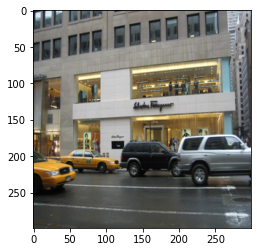

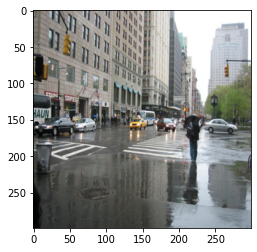

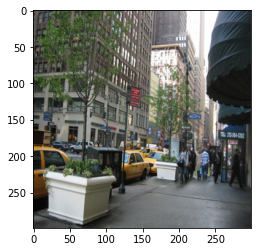

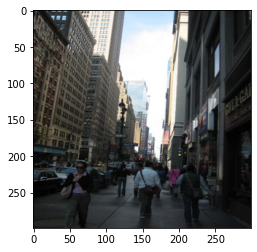

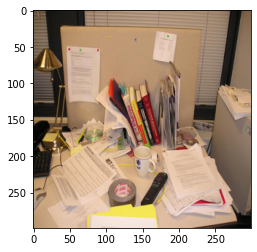

In [ ]:
for i in range(5):
  plt.imshow(X_adv[i].cpu().permute(1,2,0))
  plt.show()

### evaluation on adversarial strength, untargetted ( success rate )

In [ ]:
## Evaluation on adversarial strength (success rate)

# batch_size=20
batch_size = 5
num_batches = np.int(np.ceil(len(image_url_list1)/batch_size))
cnt=0.

counter=1
for k in tqdm_notebook(range(0,num_batches)):
    batch_size_cur=batch_size
    X_ori = torch.zeros(batch_size_cur,3,299,299).to(device) 
    X_adv=torch.zeros_like(X_ori)
    for i in range(batch_size_cur):
        # open the image using its URL
        url = image_url_list1[k*batch_size+i]
        # print(url)
        with urlopen(url) as url_response:
            image_data = url_response.read() 
        X_ori[i]=trn(Image.open(BytesIO(image_data)).resize((299, 299)))
        # print(i)
        X_adv[i]=trn(Image.open('/content/drive/MyDrive/B20AI023_DAI_Minor_1/visual_genome_perc_cw/'+str(counter)+'.jpg').resize((299, 299)))
        counter+=1
    label_adv=torch.argmax(model((X_adv-0.5)/0.5),dim=1)

    # untargeted
    label_ori=torch.argmax(model((X_ori-0.5)/0.5),dim=1)
    cnt=cnt+torch.sum(label_adv!=label_ori)

    # targeted
    # label_tar=torch.tensor(label_tar_list[k*batch_size:k*batch_size+batch_size_cur]).to(device)
    # cnt=cnt+torch.sum(label_adv==label_tar)

print(cnt/len(image_url_list1))

<ipython-input-81-4ed600203f9e>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  num_batches = np.int(np.ceil(len(image_url_list1)/batch_size))
<ipython-input-81-4ed600203f9e>:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm_notebook(range(0,num_batches)):


  0%|          | 0/10 [00:00<?, ?it/s]

tensor(0.2000, device='cuda:0')


In [ ]:
print(len(image_url_list1))

50


In [ ]:
print(cnt.item())

10.0


In [ ]:
success_rate = 1 - cnt.item()/len(image_url_list1)

In [ ]:
print('success rate untargetted : ',success_rate*100, '%')

success rate untargetted :  80.0 %


### evaluation on robustness using jpeg compression

In [ ]:
## Evaluation on robustness

def bit_depth_red(X_before,depth):
    r=256/(2**depth)
    x_quan=torch.round(X_before*255/r)*r/255 
    return x_quan

def JPEG_compression(X_before,quality):
        X_after=torch.zeros_like(X_before)
        for j in range(X_after.size(0)):
            x_np=transforms.ToPILImage()(X_before[j].detach().cpu())
            x_np.save('./'+'j.jpg',quality=quality)
            X_after[j]=trn(Image.open('./'+'j.jpg'))
        return X_after
    

# batch_size=50
batch_size = 5
num_batches = np.int(np.ceil(len(image_url_list1)/batch_size))
levels=[90,80,70,60,50,40,30]#JPEG compression ratios
# levels=[7,6,5,4,3,2]#bit depths 

num7=torch.zeros(len(levels))

counter=1
for k in tqdm_notebook(range(0,num_batches)):
    batch_size_cur=batch_size
    X_ori = torch.zeros(batch_size_cur,3,299,299).to(device) 
    X_adv_before=torch.zeros_like(X_ori)
    for i in range(batch_size_cur):
        # open the image using its URL
        url = image_url_list1[k*batch_size+i]
        # print(url)
        with urlopen(url) as url_response:
            image_data = url_response.read() 
        X_ori[i]=trn(Image.open(BytesIO(image_data)).resize((299, 299)))
        X_adv_before[i]=trn(Image.open('/content/drive/MyDrive/B20AI023_DAI_Minor_1/visual_genome_perc_cw/'+str(counter)+'.jpg').resize((299, 299)))
        counter+=1

    label_ori=torch.argmax(model((X_ori-0.5)/0.5),dim=1)
    label_adv_before=torch.argmax(model((X_adv_before-0.5)/0.5),dim=1)

    for i,value in enumerate(levels):
#         X_adv_after=bit_depth_red(X_adv_before,value)
        X_adv_after=JPEG_compression(X_adv_before,value)
        for k in range(1):
            label_after=torch.argmax(model((X_adv_after-0.5)/0.5),dim=1)
            num7[i]=num7[i]+torch.sum(label_after!=label_ori)

print(num7/len(image_url_list1))

<ipython-input-86-9345f583ce73>:19: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  num_batches = np.int(np.ceil(len(image_url_list1)/batch_size))
<ipython-input-86-9345f583ce73>:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm_notebook(range(0,num_batches)):


  0%|          | 0/10 [00:00<?, ?it/s]

tensor([0.2200, 0.2400, 0.2200, 0.2000, 0.3200, 0.3800, 0.3200])


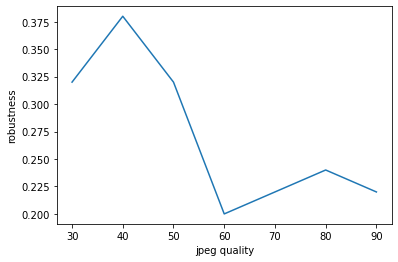

In [ ]:
plt.plot(levels,(num7/len(image_url_list1)).tolist())
plt.xlabel('jpeg quality')
plt.ylabel('robustness')
plt.show()

### evaluation on robustness using bit depth

In [ ]:
## Evaluation on robustness

def bit_depth_red(X_before,depth):
    r=256/(2**depth)
    x_quan=torch.round(X_before*255/r)*r/255 
    return x_quan

def JPEG_compression(X_before,quality):
        X_after=torch.zeros_like(X_before)
        for j in range(X_after.size(0)):
            x_np=transforms.ToPILImage()(X_before[j].detach().cpu())
            x_np.save('./'+'j.jpg',quality=quality)
            X_after[j]=trn(Image.open('./'+'j.jpg'))
        return X_after
    

# batch_size=50
batch_size =5
num1_batches = np.int(np.ceil(len(image_url_list1)/batch_size))
#levels=[90,80,70,60,50,40,30]#JPEG compression ratios
levels=[7,6,5,4,3,2]#bit depths 

num8=torch.zeros(len(levels))

counter=1
for k in tqdm_notebook(range(0,num1_batches)):
    batch_size_cur=batch_size
    X_ori = torch.zeros(batch_size_cur,3,299,299).to(device) 
    X_adv_before=torch.zeros_like(X_ori)
    for i in range(batch_size_cur):
        # open the image using its URL
        url = image_url_list1[k*batch_size+i]
        # print(url)
        with urlopen(url) as url_response:
            image_data = url_response.read()  
        X_ori[i]=trn(Image.open(BytesIO(image_data)).resize((299, 299)))
        X_adv_before[i]=trn(Image.open('/content/drive/MyDrive/B20AI023_DAI_Minor_1/visual_genome_perc_cw/'+str(counter)+'.jpg').resize((299, 299)))
        counter+=1

    label_ori=torch.argmax(model((X_ori-0.5)/0.5),dim=1)
    label_adv_before=torch.argmax(model((X_adv_before-0.5)/0.5),dim=1)

    for i,value in enumerate(levels):
        X_adv_after=bit_depth_red(X_adv_before,value)
        #X_adv_after=JPEG_compression(X_adv_before,value)
        for k in range(1):
            label_after=torch.argmax(model((X_adv_after-0.5)/0.5),dim=1)
            num8[i]=num8[i]+torch.sum(label_after!=label_ori)

print(num8/len(image_url_list1))

<ipython-input-88-92e742833c84>:19: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  num1_batches = np.int(np.ceil(len(image_url_list1)/batch_size))
<ipython-input-88-92e742833c84>:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm_notebook(range(0,num1_batches)):


  0%|          | 0/10 [00:00<?, ?it/s]

tensor([0.2000, 0.2200, 0.2400, 0.2800, 0.4200, 0.5000])


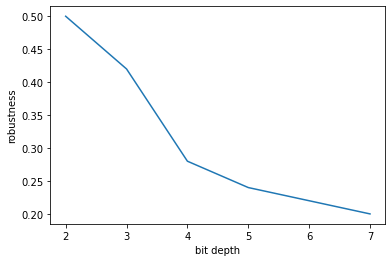

In [ ]:
plt.plot(levels,(num8/len(image_url_list1)).tolist())
plt.xlabel('bit depth')
plt.ylabel('robustness')
plt.show()

### Evaluation on tranferability

In [ ]:
model2 = models.googlenet(pretrained=True,transform_input=False).eval()
for param in model2.parameters():
    param.requires_grad=False
device  = torch.device("cuda:0")
model2.to(device)

model3 = models.vgg16_bn(pretrained=True).eval()
for param in model3.parameters():
    param.requires_grad=False
device  = torch.device("cuda:0")
model3.to(device)

model4 = models.resnet152(pretrained=True).eval()
for param in model4.parameters():
    param.requires_grad=False
device  = torch.device("cuda:0")
model4.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
#find eligible images for tranferability
#batch_size=10
batch_size = 5
num_batches = np.int(np.ceil(len(image_url_list1)/batch_size))
eligible_list_vg_cw=[]
for k in tqdm_notebook(range(0,num_batches)):
    batch_size_cur=batch_size
    X_ori = torch.zeros(batch_size_cur,3,299,299).to(device) 
    for i in range(batch_size_cur): 
        # open the image using its URL
        url = image_url_list1[k*batch_size+i]
        # print(url)
        with urlopen(url) as url_response:
            image_data = url_response.read()  
        X_ori[i]=trn(Image.open(BytesIO(image_data)).resize((299, 299)))

    pre_ori_1=torch.argmax(model((X_ori-0.5)/0.5),dim=1)
    pre_ori_2=torch.argmax(model2((X_ori-0.5)/0.5),dim=1)
    pre_ori_3=torch.argmax(model3(norm(X_ori)),dim=1)
    pre_ori_4=torch.argmax(model4(norm(X_ori)),dim=1)
    mask=((pre_ori_1==pre_ori_2).float() * (pre_ori_1==pre_ori_3).float() * (pre_ori_1==pre_ori_4).float() * (pre_ori_2==pre_ori_3).float() * (pre_ori_2==pre_ori_4).float() * (pre_ori_3==pre_ori_4).float())
    eligible_list_vg_cw.append(mask)
image_transfer_list_vg_cw=[]
for i in range(len(eligible_list_vg_cw)):
    for j in range(batch_size):
        if eligible_list_vg_cw[i][j]==1:
            image_transfer_list_vg_cw.append(image_url_list1[i*batch_size+j])

<ipython-input-171-8ffae907dd1b>:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  num_batches = np.int(np.ceil(len(image_url_list1)/batch_size))
<ipython-input-171-8ffae907dd1b>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm_notebook(range(0,num_batches)):


  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
print(eligible_list_vg_cw[:10])
print(len(eligible_list_vg_cw))
print(image_transfer_list_vg_cw[:10])
print(len(image_transfer_list_vg_cw))

[tensor([0., 0., 1., 0., 0.], device='cuda:0'), tensor([0., 1., 0., 1., 0.], device='cuda:0'), tensor([1., 1., 1., 0., 0.], device='cuda:0'), tensor([1., 0., 1., 0., 0.], device='cuda:0'), tensor([0., 0., 1., 0., 0.], device='cuda:0'), tensor([0., 1., 0., 0., 1.], device='cuda:0'), tensor([1., 0., 0., 0., 1.], device='cuda:0'), tensor([0., 0., 1., 0., 0.], device='cuda:0'), tensor([1., 1., 0., 0., 0.], device='cuda:0'), tensor([1., 0., 1., 0., 1.], device='cuda:0')]
10
['https://cs.stanford.edu/people/rak248/VG_100K/3.jpg', 'https://cs.stanford.edu/people/rak248/VG_100K/7.jpg', 'https://cs.stanford.edu/people/rak248/VG_100K/9.jpg', 'https://cs.stanford.edu/people/rak248/VG_100K/11.jpg', 'https://cs.stanford.edu/people/rak248/VG_100K/12.jpg', 'https://cs.stanford.edu/people/rak248/VG_100K/13.jpg', 'https://cs.stanford.edu/people/rak248/VG_100K/16.jpg', 'https://cs.stanford.edu/people/rak248/VG_100K/18.jpg', 'https://cs.stanford.edu/people/rak248/VG_100K/23.jpg', 'https://cs.stanford.edu

### transferability

In [ ]:

#calculate tranferability
num_batches = np.int(np.ceil(len(image_transfer_list_vg)/batch_size))
# adv_folder='./images_cw_untar_9000_1_k_40/'
adv_folder = '/content/drive/MyDrive/B20AI023_DAI_Minor_1/visual_genome_perc_cw'
sr_1=0
sr_2=0
sr_3=0
sr_4=0

counter=1
for k in tqdm_notebook(range(0,num_batches)):
    batch_size_cur=batch_size
    X_ori = torch.zeros(batch_size_cur,3,299,299).to(device) 
    x_adv = torch.zeros(batch_size_cur,3,299,299).to(device) 
    for i in range(batch_size_cur): 
        # open the image using its URL
        url = image_url_list1[k*batch_size+i]
        # print(url)
        with urlopen(url) as url_response:
            image_data = url_response.read()
        X_ori[i]=trn(Image.open(BytesIO(image_data)).resize((299, 299)))
        x_adv[i]=trn(Image.open('/content/drive/MyDrive/B20AI023_DAI_Minor_1/visual_genome_perc_cw/'+str(counter)+'.jpg').resize((299, 299)))
        #plt.imshow(X_ori[i].cpu().permute(1,2,0))
        #plt.imshow(x_adv[i].cpu().permute(1,2,0))
        plt.show()
        counter+=1
    pre_ori=torch.argmax(model((X_ori-0.5)/0.5),dim=1)
    
    pre_adv=torch.argmax(model((x_adv-0.5)/0.5),dim=1)
    pre_adv_2=torch.argmax(model2((x_adv-0.5)/0.5),dim=1)
    pre_adv_3=torch.argmax(model3(norm(X_ori)),dim=1)
    pre_adv_4=torch.argmax(model4(norm(X_ori)),dim=1)
    sr_1=sr_1+sum((pre_ori!=pre_adv).float())
    sr_2=sr_2+sum((pre_ori!=pre_adv_2).float())
    sr_3=sr_3+sum((pre_ori!=pre_adv_3).float())
    sr_4=sr_4+sum((pre_ori!=pre_adv_4).float())
print(sr_1/len(image_transfer_list_vg),sr_2/len(image_transfer_list_vg),sr_3/len(image_transfer_list_vg),sr_4/len(image_transfer_list_vg))

<ipython-input-173-f08b1e787f3b>:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  num_batches = np.int(np.ceil(len(image_transfer_list_vg)/batch_size))
<ipython-input-173-f08b1e787f3b>:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm_notebook(range(0,num_batches)):


  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.2105, device='cuda:0') tensor(0.4211, device='cuda:0') tensor(0.3684, device='cuda:0') tensor(0.3158, device='cuda:0')


In [ ]:
print(sr_1.item())
print(sr_2.item())
print(sr_3.item())
print(sr_4.item())

4.0
8.0
7.0
6.0


## plots with new dataset

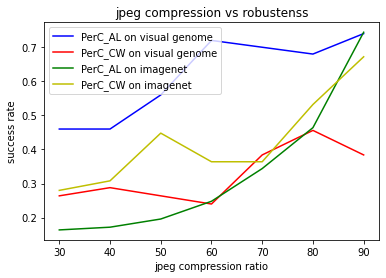

In [ ]:
plt.plot([90,80,70,60,50,40,30],num5/len(image_url_list1), 'b-', label ='PerC_AL on visual genome')
plt.plot([90,80,70,60,50,40,30],num7/len(image_url_list1), 'r-', label = 'PerC_CW on visual genome')
plt.plot([90,80,70,60,50,40,30],num/len(image_id_list), 'g-', label ='PerC_AL on imagenet')
plt.plot([90,80,70,60,50,40,30],num2/len(image_id_list), 'y-', label ='PerC_CW on imagenet')

plt.xlabel('jpeg compression ratio')
plt.ylabel('success rate')
plt.legend()
plt.title('jpeg compression vs robustenss')
plt.show()

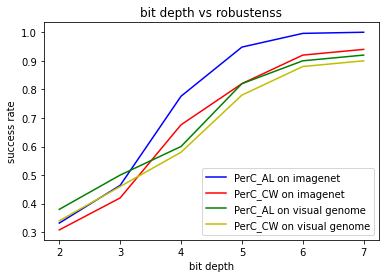

In [ ]:
plt.plot([7,6,5,4,3,2],num1/len(image_id_list), 'b-', label ='PerC_AL on imagenet')
plt.plot([7,6,5,4,3,2],num3/len(image_id_list), 'r-', label = 'PerC_CW on imagenet')
plt.plot([7,6,5,4,3,2],num6/len(image_url_list1), 'g-', label ='PerC_AL on visual genome')
plt.plot([7,6,5,4,3,2],num8/len(image_url_list1), 'y-', label = 'PerC_CW on visual genome')
plt.xlabel('bit depth')
plt.ylabel('success rate')
plt.legend()
plt.title('bit depth vs robustenss')
plt.show()

In [ ]:
original = []
x_perc_al = []
x_perc_cw = []

counter = 1
for i in image_id_list[:7]:  
    original.append(trn(Image.open(os.path.join('/content/drive/MyDrive/B20AI023_DAI_Minor_1/dataset/images',i)+'.png')))
    x_perc_al.append(trn(Image.open('/content/drive/MyDrive/B20AI023_DAI_Minor_1/images_adv_PerC_AL/'+i+'.png')))
    x_perc_cw.append(trn(Image.open('/content/drive/MyDrive/B20AI023_DAI_Minor_1/images_adv_PerC_CW/'+i+'.png')))
    

In [ ]:
counter = 1
original_vg = []
x_perc_vg_al = []
x_perc_vg_cw = []

for i in range(7): 
    url = image_url_list1[i]
    # print(url)
    with urlopen(url) as url_response:
        image_data = url_response.read()
    original_vg.append(trn(Image.open(BytesIO(image_data)).resize((299, 299))))
    x_perc_vg_al.append(trn(Image.open('/content/drive/MyDrive/B20AI023_DAI_Minor_1/visual_genome_perc_al/'+str(counter)+'.jpg').resize((299, 299))))
    x_perc_vg_cw.append(trn(Image.open('/content/drive/MyDrive/B20AI023_DAI_Minor_1/visual_genome_perc_cw/'+str(counter)+'.jpg').resize((299, 299))))
    counter+=1



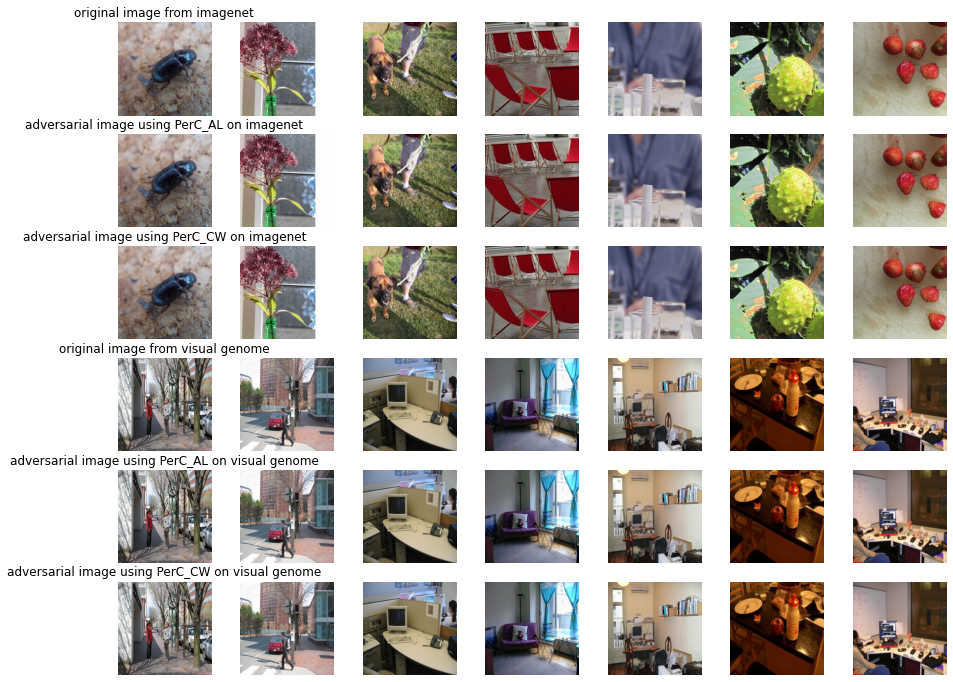

In [ ]:
fig, axs = plt.subplots(6, 7, figsize=(15, 12))

# Iterate over each image in the lists and plot them on the subplots
for i in range(7):
    axs[0, i].imshow(original[i].permute(1, 2, 0).cpu().numpy())
    axs[0, i].axis('off')
    axs[1, i].imshow(x_perc_al[i].permute(1, 2, 0).cpu().numpy())
    axs[1, i].axis('off')
    axs[2, i].imshow(x_perc_cw[i].permute(1, 2, 0).cpu().numpy())
    axs[2, i].axis('off')
    axs[3, i].imshow(original_vg[i].permute(1, 2, 0).cpu().numpy())
    axs[3, i].axis('off')
    axs[4, i].imshow(x_perc_vg_al[i].permute(1, 2, 0).cpu().numpy())
    axs[4, i].axis('off')
    axs[5, i].imshow(x_perc_vg_cw[i].permute(1, 2, 0).cpu().numpy())
    axs[5, i].axis('off')

# Set the title of each row
axs[0, 0].set_title('original image from imagenet')
axs[1, 0].set_title('adversarial image using PerC_AL on imagenet')
axs[2, 0].set_title('adversarial image using PerC_CW on imagenet')
axs[3, 0].set_title('original image from visual genome')
axs[4, 0].set_title('adversarial image using PerC_AL on visual genome')
axs[5, 0].set_title('adversarial image using PerC_CW on visual genome')

# Display the figure
plt.show()

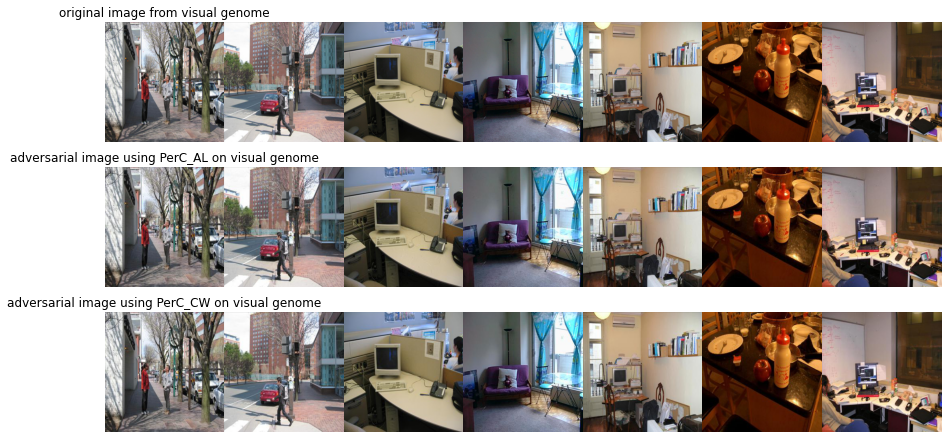

In [ ]:
fig, axs = plt.subplots(3, 7, figsize=(15, 8))
fig.subplots_adjust(wspace=0, hspace=0)

# Iterate over each image in the lists and plot them on the subplots
for i in range(7):
    axs[0, i].imshow(original_vg[i].permute(1, 2, 0).cpu().numpy())
    axs[0, i].axis('off')
    axs[1, i].imshow(x_perc_vg_al[i].permute(1, 2, 0).cpu().numpy())
    axs[1, i].axis('off')
    axs[2, i].imshow(x_perc_vg_cw[i].permute(1, 2, 0).cpu().numpy())
    axs[2, i].axis('off')

# Set the title of each row

axs[0, 0].set_title('original image from visual genome')
axs[1, 0].set_title('adversarial image using PerC_AL on visual genome')
axs[2, 0].set_title('adversarial image using PerC_CW on visual genome')

# Display the figure
plt.show()

<center><h2> THANK YOU !!</h2 </center>